# ACIT5900: Master Thesis
### *System Architecture*

>-------------------------------------------
> *Spring 2025*

>--------------------------------------------

<a id="top"></a>
1. [**Data Preparation and Representation**](#processing)<br>
    1.1 [**Load Dataset and Models**](#load) <br>
    1.2 [**Document Chunking**](#split) <br>
    1.3 [**Create Vector Store**](#database) <br>
    1.4 [**Topic Modeling**](#topic-modeling) <br>
2. [**Summary Generation and Evaluation**](#generation)<br>
    2.1 [**Generate Baseline Summaries**](#generate-summaries) <br>
    2.2 [**Compare with Abstracts Using Cosine Similarity**](#comparison) <br>
    2.3 [**Grid Search for LLM Generation Parameters**](#grid-search1) <br>
    2.4 [**Apply Best Parameters and Re-Evaluate Summaries**](#best-params) <br>
    2.5 [**Example Summary Output**](#example1) <br>
3. [**Summary Refinement and Model Comparison**](#refinement)<br>
    3.1 [**Iterative Summary Refinement Using an LLM Judge**](#llm-judge) <br>
    3.2 [**Grid Search for Refinement Parameters**](#grid-search2) <br>
    3.3 [**Evaluate Final Refined Summaries per Model**](#final-eval) <br>
    3.4 [**Statistical Significance Testing**](#llm-significance) <br>
    3.5 [**Control Study: Shuffled Abstracts**](#shuffle) <br>
4. [**Hallucination Detection**](#hallucination) <br>
    4.1 [**Sentence Processing**](#sentence-processing) <br>
    4.2 [**Compute Sentence Similarities and Thresholds**](#similarities) <br>
    4.3 [**Detect Hallucinations in Model-Generated Summaries**](#identify-hallucinations) <br>
    4.4 [**Multi-Article Detection**](#multi-article-detection) <br>
    4.5 [**Overall Hallucination Trends**](#trends) <br>
5. [**HaluEval Benchmark Case Study**](#case-study) <br>
    5.1 [**Load and Process Dataset**](#load-process) <br>
    5.2 [**Detect Sentence-Level Hallucinations**](#max-cosine) <br>
    5.3 [**Compare Sentences against Ground Truth Summaries**](#comparison2) <br>
    5.4 [**Evaluate Summary-Level Classification Metrics**](#summary-eval) <br>
    5.5 [**Categorize Sentences and Analyze Distribution**](#classification-visuals) <br>

In [1]:
# remove old Chroma db before new run
!rm -rf chroma_db

In [2]:
# install dependencies
!pip install langchain langchain-chroma langchain-community chromadb bertopic bert-score langchain-huggingface jedi

In [3]:
# general utilities
import re
import json
import torch
import random
import difflib
import textwrap
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import product

# NLP resources
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# modeling and evaluation
from bertopic import BERTopic
from huggingface_hub import login
from scipy.signal import argrelextrema
from scipy.stats import wilcoxon, gaussian_kde
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, logging
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

# clustering and dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# LangChain components
from langchain.chains import RetrievalQA
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# ignore warnings from transformers library
logging.set_verbosity_error()

In [5]:
def set_seed(seed=42):
    """
    Set random seed for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## <a id="processing"></a> 1) Data Preparation and Representation

### <a id="load"></a> 1.1) Load Dataset and Models

This section initializes the data and models required for the pipeline. It starts by loading a pre-cleaned dataset from a CSV file using `pandas`. Next, it authenticates with the Hugging Face Hub to access pretrained language models. A dictionary of available models is defined, and one model is selected for use. The corresponding tokenizer and language model are then loaded. Additionally, a separate embedding model, `"all-MiniLM-L6-v2"`, is loaded to generate dense vector representations of text. These embeddings will be used for tasks such as information retrieval.

[⬆️ Back to Top](#top)

In [6]:
file_path = '/content/df_cleaned.csv'

# read data frame
df = pd.read_csv(file_path)
df.head()

title  \
0  Advanced Passive Operating System Fingerprinti...   
1  Artificial intelligence in the fertility clini...   
2  EvoDynamic: A Framework for the Evolution of G...   
3  A general representation of dynamical systems ...   
4  Exploring Multilingual Word Embedding Alignmen...   

                                             authors  year_published   number  \
0  Hagos, Desta Haileselassie and Løland, Martin ...            2020  missing   
1  Riegler, M A and Stensen, M H and Witczak, O a...            2021      9.0   
2  Pontes-Filho, Sidney\nand Lind, Pedro\nand Yaz...            2020  missing   
3  Sidney Pontes{-}Filho and\nAnis Yazidi and\nJi...            2019  missing   
4  Aaby, Pernille\nand Biermann, Daniel\nand Yazi...            2023  missing   

           volume             journal           type  \
0         missing             missing  inproceedings   
1              36  Human Reproduction        article   
2         missing             missing  inproceedings   
3  abs/1907.01856                CoRR        article   
4         missing             missing  inproceedings   

                                             content  \
0  Advanced Passive Operating System Fingerprinti...   
1  .................................................   
2  EvoDynamic: a framework for the evolution of\n...   
3  A general representation of dynamical systems ...   
4   \n \n \n \nAccepted manuscript \nAaby, P., Bi...   

                               doi   file  \
0  10.1109/ICCCN49398.2020.9209694  doc28   
1           10.1093/humrep/deab168  doc14   
2                          missing  doc10   
3                          missing  doc11   
4                          missing  doc12   

                                            abstract  \
0  —Securing and managing large, complex enterpri...   
1  : In recent years, the amount of data produced...   
2  . Dynamical systems possess a computational ca...   
3  —Dynamical systems are capable of performing c...   
4  . Contextual language models, such as transfor...   

                                     cleaned_content  \
0  Advanced Passive Operating System Fingerprinti...   
1  .................................................   
2  EvoDynamic: a framework for the evolution of g...   
3  A general representation of dynamical systems ...   
4  Accepted manuscript Aaby, P., Biermann, D., Ya...   

                                    cleaned_abstract  \
0  —Securing and managing large, complex enterpri...   
1  : In recent years, the amount of data produced...   
2  . Dynamical systems possess a computational ca...   
3  —Dynamical systems are capable of performing c...   
4  . Contextual language models, such as transfor...   

                                     cleaned_authors  
0  ['Desta Haileselassie Hagos', 'Martin Løland',...  
1  ['M A Riegler', 'M H Stensen', 'O Witczak', 'J...  
2  ['Sidney Pontes-Filho', 'Pedro Lind', 'Anis Ya...  
3  ['Sidney Pontes-Filho', 'Anis Yazidi', 'Jianhu...  
4  ['Pernille Aaby', 'Daniel Biermann', 'Anis Yaz...

In [7]:
# authenticate with the Hugging Face Hub
login()

In [8]:
# define available models
available_models = {
    "Llama3": "meta-llama/Llama-3.2-1B-Instruct",
    "Falcon3": "tiiuae/Falcon3-1B-Instruct",
    "Granite": "ibm-granite/granite-3.0-1b-a400m-instruct"
}

# choose model
selected_model = available_models["Llama3"]

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(selected_model)
llm_model = AutoModelForCausalLM.from_pretrained(selected_model)
llm_model.config.pad_token_id = tokenizer.eos_token_id

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
llm_model = llm_model.to(device)

In [9]:
# load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

### <a id="split"></a> 1.2) Document Chunking

This section prepares the dataset for retrieval and semantic analysis by converting each row in the dataframe into a structured LangChain `Document` object. Each document includes the main text content as well as metadata such as the title, file name, authors, abstract, and publication year. To enable efficient processing and retrieval, each document is then split into smaller overlapping text chunks using a recursive character-based text splitter. The number of chunks is tracked per document and logged for inspection. These chunks serve as the basic units for later embedding, indexing, and retrieval tasks.

[⬆️ Back to Top](#top)

In [10]:
# convert each row into a langchain document
documents = [
    Document(page_content=row["cleaned_content"], metadata={"title": row["title"], "authors": row["authors"], "file": row["file"], "year_published": row["year_published"], "abstract": row["abstract"]})
    for _, row in df.iterrows()
]

In [11]:
def split_documents(documents, chunk_size=500, chunk_overlap=50):
    """
    Splits list of documents into smaller chunks for easier processing.

    Args:
        documents: list of documents to be split into chunks.
        chunk_size: maximum size of each chunk in characters.
        chunk_overlap: number of overlapping characters between consecutive chunks.

    Returns:
        tuple: containing chunks of text chunks after splitting and chunk_counts for dictionary with
        count of chunks per document, using file name as key.
    """
    # initialize a character-based splitter with set separators
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )

    chunks = []
    chunk_counts = {}

    for doc in documents:

        # split each document into chunks
        doc_chunks = text_splitter.split_documents([doc])

        # record the number of chunks for this document using its filename
        chunk_counts[doc.metadata["file"]] = len(doc_chunks)

        for chunk in doc_chunks:

            # ensure file metadata is carried over to each chunk
            chunk.metadata["file"] = doc.metadata["file"]
            chunks.append(chunk)

    print(f"Total chunks created: {len(chunks)} \n")
    return chunks, chunk_counts

chunked_documents, chunk_counts = split_documents(documents)

Total chunks created: 1969 



In [12]:
# display chunking info for a few documents
for doc in documents[:4]:
    num_chunks = chunk_counts.get(doc.metadata["file"], 0)
    print(f"File: {doc.metadata['file']}")
    print(f"Original document length: {len(doc.page_content)}")
    print(f"Number of chunks: {num_chunks}\n")

File: doc28
Original document length: 66818
Number of chunks: 149

File: doc14
Original document length: 68223
Number of chunks: 153

File: doc10
Original document length: 34247
Number of chunks: 77

File: doc11
Original document length: 22320
Number of chunks: 50



### <a id="database"></a> 1.3) Create Vector Store

This section creates and manages a vector database for efficient document retrieval and topic modeling. First, the chunked documents are embedded using a sentence transformer and stored in a Chroma vector database. The database is then validated to ensure all chunks are properly indexed. To analyze the high-dimensional embeddings, dimensionality reduction techniques like PCA and T-SNE are applied, followed by KMeans clustering to identify groupings.

[⬆️ Back to Top](#top)

In [13]:
# create Chroma vector database
vectorstore = Chroma.from_documents(documents=chunked_documents, embedding=embedding_model, persist_directory="chroma_db")

In [14]:
# load existing Chroma vector database
vectorstore = Chroma(persist_directory="chroma_db", embedding_function=embedding_model)

# define retriever
retriever = vectorstore.as_retriever()

In [15]:
# check the number of documents stored in ChromaDB
stored_count = vectorstore._collection.count()
expected_count = len(chunked_documents)

print(f"Stored documents in ChromaDB: {stored_count}")
print(f"Expected text splits: {expected_count}")

# validate indexing success
if stored_count == expected_count:
    print("All text splits are correctly stored in ChromaDB.")
else:
    print(f"Mismatch detected: {expected_count - stored_count} documents missing.")
    print("Some documents might not have been indexed properly.")


Stored documents in ChromaDB: 1969
Expected text splits: 1969
All text splits are correctly stored in ChromaDB.


In [ ]:
# load embeddings from Chroma
embeddings = vectorstore._collection.get(include=['embeddings'])['embeddings']
document_embeddings = np.array(embeddings)

# reduce dimensions with PCA to speed up TSNE
pca = PCA(n_components=50)
pca_embeddings = pca.fit_transform(document_embeddings)

In [ ]:
# apply T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

# apply KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels_tsne = kmeans.fit_predict(tsne_embeddings)

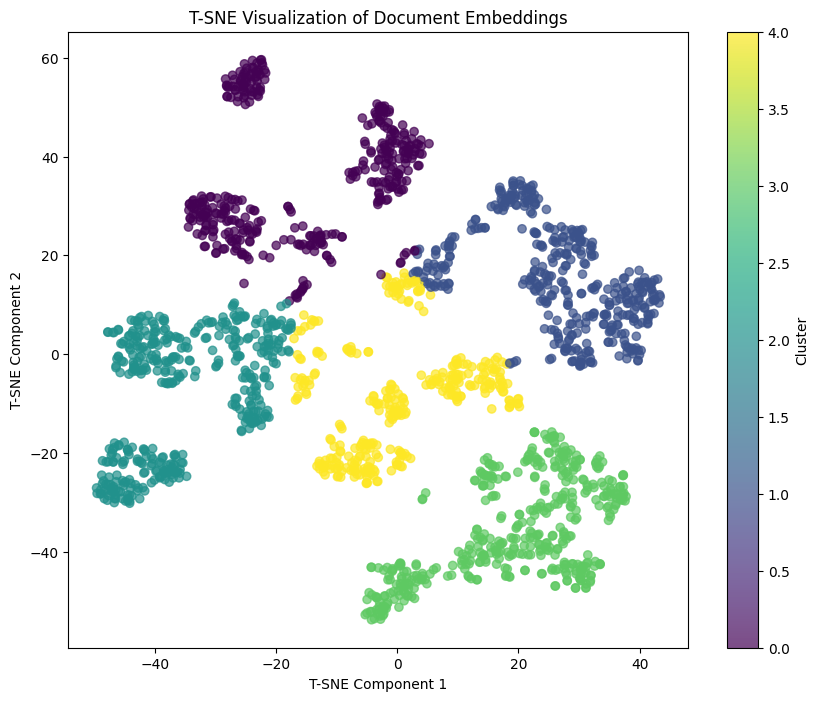

In [ ]:
# plot T-SNE
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels_tsne, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("T-SNE Visualization of Document Embeddings")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.show()

### <a id="topic-modeling"></a> 1.4) Topic Modeling

This section applies topic modeling to the document collection using the BERTopic framework. The process begins by preprocessing each document by lowercasing, tokenizing, stripping of English stopwords, and lemmatizing using NLTK. These preprocessed texts are then used to train a BERTopic model, which clusters documents based on semantic similarity and extracts interpretable topics. After fitting the model, a summary of discovered topics is retrieved, and a bar chart is generated for visualization. This helps in understanding the dominant topics within the dataset and provides insights into its semantic structure.

[⬆️ Back to Top](#top)

In [ ]:
def preprocess_text(text):
    """
    Preprocesses the input text by tokenizing, removing stopwords, and lemmatizing.

    Args:
        text: The input text to be preprocessed.

    Returns:
        str: The preprocessed text as a space-separated string of lemmatized tokens.
    """

    # tokenize text
    tokens = nltk.word_tokenize(text.lower())

    # remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [ ]:
# extract text documents
documents = vectorstore._collection.get(include=['documents'])['documents']

# apply preprocessing to each document
preprocessed_documents = [preprocess_text(doc) for doc in documents]

# initialize BERTopic
topic_model = BERTopic()

# fit model on preprocessed documents
topics, probs = topic_model.fit_transform(preprocessed_documents)

# get topic info
topic_info = topic_model.get_topic_info()

# visualize the topics
topic_model.visualize_barchart(top_n_topics=8)

## <a id="generation"></a> 2) Summary Generation and Evaluation

### <a id="generate-summaries"></a> 2.1) Generate Baseline Summaries

This section defines a function that generates summaries of research articles at two different levels of complexity: basic and specialized. The process begins by retrieving relevant documents based on the article title using a retrieval module. Two distinct prompts are then formulated: one designed for a general audience (basic) and another for domain experts (specialized). These prompts are passed through a retrieval-augmented QA chain to generate summaries tailored to each audience. The function returns both the retrieved documents and the generated summaries, forming a foundation for later evaluation of how effectively the model adapts its output to different levels of technical understanding.

[⬆️ Back to Top](#top)


In [16]:
# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sentence embeddings
sim_model = SentenceTransformer("all-mpnet-base-v2")

In [17]:
def generate_summaries(title, retriever, qa_chain):
    """
    Retrieves relevant documents and generates two summaries (basic and specialized) for a research article.

    Args:
        title: The title of the article.
        retriever: The document retriever.
        qa_chain: The QA chain used to generate summaries.

    Returns:
        dict: A dictionary containing the retrieved documents and generated summaries at two levels.
    """

    # retrieve relevant documents based on the article title
    retrieved_docs = retriever.invoke(title)
    if not retrieved_docs:
        return {"retrieved_docs": [], "generated_summaries": {}}

    queries = {
    "basic": f"Provide a simple, non-technical summary of the research article titled '{title}'. Use clear language suitable for a general audience and avoid complex terminology, notes, or references.",
    "specialized": f"Provide a concise, technical summary of the research article titled '{title}', using domain-specific language appropriate for experts. Do not include additional notes, comments, or references."
    }

    summaries = {}

    # generate summary for each level
    for level, query in queries.items():

        # invoke QA chain with current query and retrieved documents
        response = qa_chain.invoke(input={"query": query, "documents": retrieved_docs})

        # extract summary text from response
        summaries[level] = response.get("result", "").split("Answer:")[-1].strip()

    return {
        "retrieved_docs": [doc.page_content for doc in retrieved_docs],
        "generated_summaries": summaries,
    }

### <a id="comparison"></a> 2.2) Compare with Abstracts Using Cosine Similarity

This section evaluates the quality of generated summaries by comparing them to the original abstract of a research article. The process is structured into three main steps:

1. **Summary Retrieval**: The `abstract_summary_comparison` function retrieves the original abstract, relevant context documents, and the model-generated summaries for a given article.

2. **Automated Evaluation**: Each summary is evaluated using sentence embeddings to compute cosine similarity against the original abstract to measure **faithfulness** (semantic alignment).

3. **Metric Reporting**: The `final_summary_evaluation` function combines these scores into a dictionary of evaluation metrics for each summary. This allows comparison of how well each summary preserves meaning and adheres to the retrieved documents.

[⬆️ Back to Top](#top)


In [18]:
def compute_cosine(text1, text2, model):
    """
    Computes the cosine similarity between two texts using the given model.

    Args:
        text1: The first text to compare.
        text2: The second text to compare.
        model: The embedding model used to generate text embeddings.

    Returns:
        float: The cosine similarity between the two texts.
    """
    embeddings = model.encode([text1, text2])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

In [19]:
def evaluate_summary(summary, abstract, context, sim_model):
    """
    Compares a summary to the abstract and context to measure its quality.

    Args:
        summary: The summary to evaluate.
        abstract: The original abstract of the article.
        context: A list of context documents.
        sim_model: The model used to calculate similarity.

    Returns:
        dict: Similarity scores for faithfulness.
    """
    full_context = " ".join(context)
    return {
        "Faithfulness (Abstract Similarity)": compute_cosine(summary, abstract, sim_model),
    }

In [20]:
def abstract_summary_comparison(article_id, df, retriever, qa_chain):
    """
    Compares the abstract with generated summaries for a given article.

    Args:
        article_id: The ID of the article in the DataFrame.
        df: The DataFrame containing article data.
        retriever: The document retriever.
        qa_chain: The QA chain for generating summaries.

    Returns:
        dict: A dictionary containing the article title, original abstract, retrieved documents,
        and generated summaries.
    """
    article = df.iloc[article_id]
    title, abstract = article["title"], article["abstract"]
    summary_data = generate_summaries(title, retriever, qa_chain)

    return {
        "title": title,
        "original_abstract": abstract,
        "retrieved_docs": summary_data["retrieved_docs"],
        "generated_summaries": summary_data["generated_summaries"]
    }

In [21]:
def final_summary_evaluation(article_id, df, retriever, qa_chain, sim_model):
    """
    Evaluates the generated summaries for an article by comparing them to the original abstract and context.

    Args:
        article_id: The ID of the article in the DataFrame.
        df: The DataFrame containing article data.
        retriever: The document retriever.
        qa_chain: The QA chain for generating summaries.
        sim_model: The model used to calculate similarity.

    Returns:
        dict: A dictionary with evaluation metrics for each generated summary.
    """

    # generate summaries and retrieve original abstract and supporting context
    comparison = abstract_summary_comparison(article_id, df, retriever, qa_chain)
    original_abstract = comparison["original_abstract"]
    context = comparison["retrieved_docs"]
    evaluation_results = {}

    # evaluate each summary against abstract and retrieved context
    for level, summary in comparison["generated_summaries"].items():
        metrics = evaluate_summary(summary, original_abstract, context, sim_model)
        evaluation_results[level] = metrics

    return evaluation_results

### <a id="grid-search1"></a> 2.3) Grid Search for LLM Generation Parameters

This section fine-tunes key generation parameters (maximum token length, temperature, and repetition penalty) to improve the quality of summaries produced by the language model. A grid search is used to evaluate multiple parameter combinations, scoring each configuration based on semantic similarity to the original abstract and supporting context. The best-performing configuration is saved for later use.

[⬆️ Back to Top](#top)

In [22]:
def grid_search_summary_evaluation(llm_model, tokenizer, retriever, df, sim_model, article_ids):
    """
    Runs a grid search over generation parameters to find the configuration that
    maximizes the average improvement from the basic to the specialized summary.

    Args:
        llm_model: The language model to use for generation.
        tokenizer: The tokenizer associated with the model.
        retriever: The document retriever.
        df: The DataFrame containing article data.
        sim_model: Model used to compute semantic similarity.
        article_ids: List of article IDs to evaluate.

    Returns:
        dict: Best parameter combination based on average improvement.
    """

    # define parameter grid
    max_tokens_list = [600, 700]
    temperature_list = [0.5, 0.6, 0.7]
    repetition_penalty_list = [1.0, 1.2]

    results = []

    # iterate over all combinations of parameters
    for max_tokens, temp, rep_penalty in product(max_tokens_list, temperature_list, repetition_penalty_list):
        print(f"\nEvaluating with max_tokens={max_tokens}, temperature={temp}, repetition_penalty={rep_penalty} ...")

        # create text generation pipeline
        llm_pipeline = pipeline(
            "text-generation",
            model=llm_model,
            tokenizer=tokenizer,
            max_new_tokens=max_tokens,
            temperature=temp,
            repetition_penalty=rep_penalty,
            device=0 if torch.cuda.is_available() else -1
        )
        llm = HuggingFacePipeline(pipeline=llm_pipeline)
        qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

        improvements = []

        # evaluate summary quality for each article using current settings
        for article_id in article_ids:
            eval_scores = final_summary_evaluation(article_id, df, retriever, qa_chain, sim_model)
            basic_score = eval_scores["basic"]["Faithfulness (Abstract Similarity)"]
            spec_score = eval_scores["specialized"]["Faithfulness (Abstract Similarity)"]
            improvements.append(spec_score - basic_score)

        # compute average improvement for current parameter combination
        avg_improvement = np.mean(improvements) if improvements else 0.0

        results.append({
            "max_tokens": max_tokens,
            "temperature": temp,
            "repetition_penalty": rep_penalty,
            "avg_improvement": avg_improvement
        })

    # convert results to data frame and identify best parameter set
    df_results = pd.DataFrame(results)
    best_idx = df_results["avg_improvement"].idxmax()
    best_params = df_results.loc[best_idx, ["max_tokens", "temperature", "repetition_penalty"]].to_dict()

    print("\nBest Parameters (by improvement):", best_params)
    return best_params

In [21]:
def plot_boxplot_comparison(all_evaluations):
    """
    Plots a box plot comparing faithfulness scores (abstract similarity)
    for basic and specialized summaries across articles, using standard blue and orange colors
    and black median lines.

    Args:
        all_evaluations: List of evaluation dictionaries per article.
    """
    summary_levels = ["basic", "specialized"]
    metric = "Faithfulness (Abstract Similarity)"
    colors = ["C0", "C1"]

    # collect scores
    data = [
        [evaluation[level][metric] for evaluation in all_evaluations]
        for level in summary_levels
    ]

    plt.figure(figsize=(8, 6))
    box = plt.boxplot(data, labels=[level.capitalize() for level in summary_levels],
                      patch_artist=True)

    # set box face colors
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # set median line colors
    for median in box['medians']:
        median.set_color('black')
        median.set_linewidth(2)

    plt.ylabel("Cosine Similarity")
    plt.title("Faithfulness (Abstract Similarity) Comparison")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# define list of articles to evaluate
article_ids = list(range(len(df)))

# run grid search to find best generation parameters
best_params = grid_search_summary_evaluation(
    llm_model=llm_model,
    tokenizer=tokenizer,
    retriever=retriever,
    df=df,
    sim_model=sim_model,
    article_ids=article_ids
)


Evaluating with max_tokens=600, temperature=0.5, repetition_penalty=1.0 ...

Evaluating with max_tokens=600, temperature=0.5, repetition_penalty=1.2 ...

Evaluating with max_tokens=600, temperature=0.6, repetition_penalty=1.0 ...

Evaluating with max_tokens=600, temperature=0.6, repetition_penalty=1.2 ...

Evaluating with max_tokens=600, temperature=0.7, repetition_penalty=1.0 ...

Evaluating with max_tokens=600, temperature=0.7, repetition_penalty=1.2 ...

Evaluating with max_tokens=700, temperature=0.5, repetition_penalty=1.0 ...

Evaluating with max_tokens=700, temperature=0.5, repetition_penalty=1.2 ...

Evaluating with max_tokens=700, temperature=0.6, repetition_penalty=1.0 ...

Evaluating with max_tokens=700, temperature=0.6, repetition_penalty=1.2 ...

Evaluating with max_tokens=700, temperature=0.7, repetition_penalty=1.0 ...

Evaluating with max_tokens=700, temperature=0.7, repetition_penalty=1.2 ...

Best Parameters (by improvement): {'max_tokens': 600.0, 'temperature': 0.6,

### <a id="best-params"></a> 2.4) Apply Best Parameters and Re-Evaluate Summaries

Using the best parameters, the QA pipeline is rebuilt and applied to the full dataset. Each article is re-evaluated to compute faithfulness and context precision scores. These results are plotted to visualize how well the model performs across all articles under the optimized settings.

[⬆️ Back to Top](#top)

In [ ]:
# create text-generation pipeline with best parameters
llm_pipeline = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
    max_new_tokens=int(best_params["max_tokens"]), # max tokens to generate per response
    temperature=float(best_params["temperature"]), # controls creativity in generation
    repetition_penalty=float(best_params["repetition_penalty"]), # penalizes repeated phrases
    device=0 if torch.cuda.is_available() else -1
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

In [ ]:
all_evaluations = []

for article_id in article_ids:
    # evaluate summaries for current article using abstract and context
    eval_result = final_summary_evaluation(article_id, df, retriever, qa_chain, sim_model)
    all_evaluations.append(eval_result)

<ipython-input-29-f7dddab0529c>:21: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



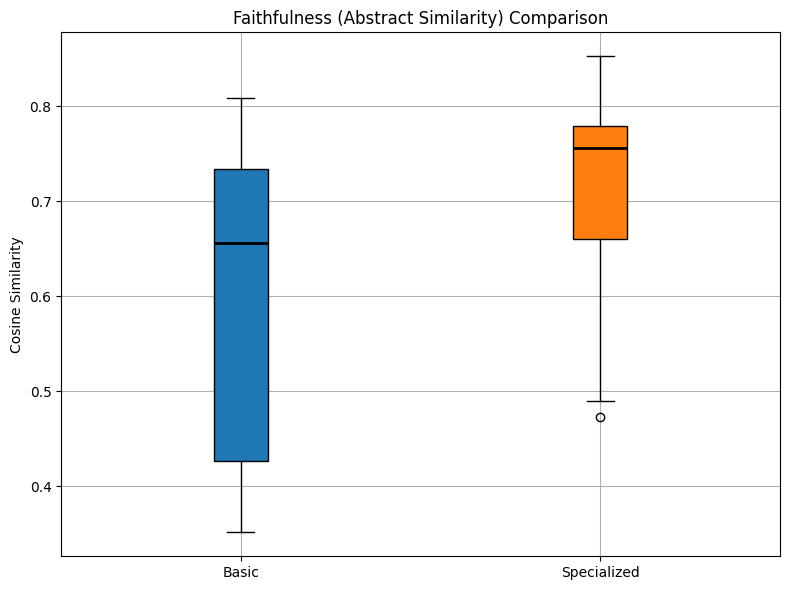

In [ ]:
# plot boxplots
plot_boxplot_comparison(all_evaluations)

### <a id="example1"></a> 2.5) Example Summary Output

Finally, an example article is selected to showcase the impact of the optimized parameters. The function prints the original abstract along with the generated basic and specialized summaries, each followed by its cosine similarity score relative to the abstract.

[⬆️ Back to Top](#top)

In [ ]:
def print_example_summary_from_best_params(best_params, llm_model, tokenizer, retriever, df, sim_model, article_id):
    """
    Prints an example summary (basic and specialized) using the best hyperparameters,
    along with cosine similarity to the original abstract.

    Args:
        best_params: The best hyperparameter combination.
        llm_model: The LLM model.
        tokenizer: Tokenizer for the LLM.
        retriever: Document retriever.
        df: DataFrame with articles.
        sim_model: Sentence transformer for similarity evaluation.
        article_id: ID of the article to show (default: 0).
    """

    # set up text generation pipeline using best parameters
    llm_pipeline = pipeline(
        "text-generation",
        model=llm_model,
        tokenizer=tokenizer,
        max_new_tokens=int(best_params["max_tokens"]),
        temperature=float(best_params["temperature"]),
        repetition_penalty=float(best_params["repetition_penalty"]),
        device=0 if torch.cuda.is_available() else -1
    )

    llm = HuggingFacePipeline(pipeline=llm_pipeline)
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

    # generate summaries and retrieve the original abstract for comparison
    comparison = abstract_summary_comparison(article_id, df, retriever, qa_chain)

    abstract = comparison["original_abstract"]
    basic_summary = comparison["generated_summaries"]["basic"]
    specialized_summary = comparison["generated_summaries"]["specialized"]

    # encode text into embeddings for cosine similarity computation
    abstract_vec = sim_model.encode([abstract])[0]
    basic_vec = sim_model.encode([basic_summary])[0]
    spec_vec = sim_model.encode([specialized_summary])[0]

    # compute cosine similarity to evaluate faithfulness
    sim_basic = cosine_similarity([basic_vec], [abstract_vec])[0][0]
    sim_spec = cosine_similarity([spec_vec], [abstract_vec])[0][0]

    # print results
    print("\n--- Example Summary Using Best Parameters ---")
    print(f"Title: {comparison['title']}\n")
    print("Original Abstract:\n", abstract, "\n")
    print(f"Generated Basic Summary (Cosine Similarity = {sim_basic:.4f}):\n{basic_summary}\n")
    print(f"Generated Specialized Summary (Cosine Similarity = {sim_spec:.4f}):\n{specialized_summary}")

In [ ]:
# print example of basic and specialized summaries for article ID
print_example_summary_from_best_params(
    best_params=best_params,
    llm_model=llm_model,
    tokenizer=tokenizer,
    retriever=retriever,
    df=df,
    sim_model=sim_model,
    article_id=2
)


--- Example Summary Using Best Parameters ---
Title: EvoDynamic: A Framework for the Evolution of Generally Represented Dynamical Systems and Its Application to Criticality

Original Abstract:
 . Dynamical systems possess a computational capacity that
may be exploited in a reservoir computing paradigm. This paper presents
a general representation of dynamical systems which is based on matrix
multiplication. That is similar to how an artiﬁcial neural network (ANN)
would be represented in a deep learning library and its computation
would be faster because of the optimized matrix operations that such
type of libraries have. Initially, we implement the simplest dynamical
system, a cellular automaton. The mathematical fundamentals behind
an ANN are maintained, but the weights of the connections and the ac-
tivation function are adjusted to work as an update rule in the context
of cellular automata. The advantages of such implementation are its us-
age on specialized and optimized deep lear

## <a id="refinement"></a> 3) Summary Refinement and Model Comparison

### <a id="llm-judge"></a> 3.1) Iterative Summary Refinement Using an LLM Judge

This section introduces an iterative approach where an LLM acts as a judge to refine generated summaries. Starting from an initial basic summary, the LLM provides revisions intended to improve faithfulness to both the retrieved documents and the original abstract. Cosine similarity is used to evaluate each revision.

[⬆️ Back to Top](#top)

In [22]:
def llm_judge(generated_summary, retrieved_docs, original_abstract, model, tokenizer,
              temperature, max_new_tokens, top_p, device='cuda'):
    """
    Uses an LLM to revise a generated summary, ensuring it aligns with retrieved documents
    and resembles a faithful academic abstract.

    Args:
        generated_summary: The initial summary to be revised.
        retrieved_docs: The supporting documents to use as factual reference.
        original_abstract: The article's original abstract (not used in revision, but could be logged).
        model: The language model for generation.
        tokenizer: Tokenizer for the model.
        temperature: Sampling temperature.
        max_new_tokens: Maximum number of tokens to generate.
        top_p: Sampling parameter.
        device: Device to run model on cuda or cpu.

    Returns:
        tuple: (rewritten summary, explanation)
    """

    # prompt instructions
    prompt = (
        "Revise the following summary so that it accurately reflects the key information from the retrieved documents."
        "Write the summary in a more advanced language and preserve important terminology from the documents.\n\n"
        "Write as a single, coherent paragraph with no bullet points or listing of concepts.\n\n"
        f"Retrieved Documents:\n{retrieved_docs}\n\n"
        f"Current Summary:\n{generated_summary}\n\n"
        "Rewritten Summary:"
    )

    # tokenize and prepare input for model
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096).to(device)

    # generate rewritten summary with specified parameters
    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        top_p=top_p,
        temperature=temperature,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )

    # decode model output
    explanation = tokenizer.decode(output[0], skip_special_tokens=True)

    # extract only rewritten summary text
    rewritten = explanation.split("Rewritten Summary:")[-1].strip()

    return rewritten, "Refined to align better with retrieved content and abstract structure."

In [23]:
def iterative_summary_refinement(article_id, df, retriever, qa_chain, model, tokenizer, sim_model,
                                 max_iterations, refinement_temperature, refinement_max_new_tokens,
                                 refinement_top_p):
    """
    Iteratively refines a generated summary using LLM feedback to improve its similarity to the original abstract.

    Args:
        article_id: Index of the article in the DataFrame.
        df: DataFrame containing articles with title and abstract.
        retriever: Document retriever to fetch relevant content.
        qa_chain: QA chain to generate the initial summary.
        model: LLM for rewriting summaries.
        tokenizer: Tokenizer for the LLM.
        sim_model: Sentence transformer for cosine similarity computation.
        max_iterations: Maximum number of refinement iterations.
        refinement_temperature: Temperature for summary generation.
        refinement_max_new_tokens: Max tokens allowed in revised summary.
        refinement_top_p: Top-p parameter.

    Returns:
        dict: Contains the article title, abstract, retrieved docs, summary versions,
        feedback history, and final summary.
    """

    device = next(model.parameters()).device

    # retrieve article title and abstract
    article = df.iloc[article_id]
    title = article["title"]
    original_abstract = article["abstract"]

    # generate initial summaries and retrieve relevant documents
    summary_data = generate_summaries(title, retriever, qa_chain)
    retrieved_docs = summary_data["retrieved_docs"]
    generated_summaries = {}

    # if no documents were retrieved, return early
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "retrieved_docs": [],
            "generated_summaries": {},
            "feedback_history": [],
            "final_specialized_summary": "",
        }

    # start refinement with the basic summary
    current_summary = summary_data["generated_summaries"]["basic"]
    generated_summaries["basic"] = current_summary

    # encode original abstract for similarity comparison
    original_vector = sim_model.encode([original_abstract])[0]
    feedback_history = []

    for iteration in range(max_iterations):
        # ask LLM to revise summary using retrieved documents
        rewritten_summary, feedback = llm_judge(
              generated_summary=current_summary,
              retrieved_docs=retrieved_docs,
              original_abstract=original_abstract,
              model=model,
              tokenizer=tokenizer,
              temperature=refinement_temperature,
              max_new_tokens=refinement_max_new_tokens,
              top_p=refinement_top_p,
              device=device
        )

        feedback_history.append((f"refined_{iteration + 1}", feedback))

        # compute similarity of revised summary to original abstract
        current_vector = sim_model.encode([rewritten_summary])[0]
        current_similarity = cosine_similarity([original_vector], [current_vector])[0][0]

        # save revised summary
        generated_summaries[f"refined_iteration_{iteration + 1}"] = rewritten_summary

        # update current_summary to carry over improvements
        current_summary = rewritten_summary

    return {
        "title": title,
        "original_abstract": original_abstract,
        "retrieved_docs": retrieved_docs,
        "generated_summaries": generated_summaries,
        "feedback_history": feedback_history,
        "final_specialized_summary": current_summary,
    }

### <a id="grid-search2"></a> 3.2) Grid Search for Refinement Parameters

To tune the quality of LLM-based refinement, a grid search is conducted over parameters such as temperature, top-p sampling, and maximum token length. For each parameter combination, the refinement pipeline is applied to a set of articles, and cosine similarity is calculated between the final refined summary and the original abstract. The configuration that yields the highest average improvement is selected. The best-performing setup is then used to evaluate the model across all articles, track similarity trends over refinement iterations, and print example summary trajectories for inspection.

[⬆️ Back to Top](#top)

In [24]:
def grid_search_for_model(df, retriever, qa_chain, model, tokenizer, sim_model, article_ids, max_iterations):
    """
    Runs a grid search to find the best generation parameters for iterative summary refinement based on cosine similarity improvement.

    Args:
        df: DataFrame of articles.
        retriever: Document retriever.
        qa_chain: Initial summary generator.
        model: LLM for refinement.
        tokenizer: Model tokenizer.
        sim_model: Embedding model for similarity scoring.
        article_ids: List of article indices.
        max_iterations: Max refinement steps per article.

    Returns:
        tuple: (best_params, data frame of parameter scores)
    """

    # define parameter grid
    temperatures = [0.3, 0.4, 0.5]
    max_new_tokens_list = [250, 350]
    top_p_list = [0.90, 0.95]

    # generate all combinations of parameters
    param_combinations = list(product(temperatures, max_new_tokens_list, top_p_list))
    results = []

    # evaluate each parameter combination
    for temp, max_tokens, top_p in param_combinations:
        print(f"\nEvaluating with temperature={temp}, max_new_tokens={max_tokens}, top_p={top_p} ...")

        improvements = []

        for article_id in article_ids:
            # run full refinement process with current parameter combination
            result = iterative_summary_refinement(
                article_id, df, retriever, qa_chain, model, tokenizer, sim_model,
                max_iterations,
                refinement_temperature=temp,
                refinement_max_new_tokens=max_tokens,
                refinement_top_p=top_p
            )

            # compute cosine similarity improvement if summaries were generated
            if result["generated_summaries"]:
                original_vector = sim_model.encode([result["original_abstract"]])[0]
                basic_summary = result["generated_summaries"]["basic"]
                final_summary = result["final_specialized_summary"]

                basic_vector = sim_model.encode([basic_summary])[0]
                final_vector = sim_model.encode([final_summary])[0]

                # compute similarity scores and improvement
                sim_basic = cosine_similarity([original_vector], [basic_vector])[0][0]
                sim_final = cosine_similarity([original_vector], [final_vector])[0][0]
                improvement = sim_final - sim_basic
                improvements.append(improvement)

        # compute average improvement for current parameter combination
        avg_improvement = np.mean(improvements) if improvements else 0.0

        results.append({
            "temperature": temp,
            "max_new_tokens": max_tokens,
            "top_p": top_p,
            "avg_improvement": avg_improvement
        })

    df_results = pd.DataFrame(results)

    # identify the best parameter combination by maximum average improvement
    best_idx = df_results["avg_improvement"].idxmax()
    best_params = df_results.loc[best_idx, ["temperature", "max_new_tokens", "top_p"]].to_dict()
    return best_params, df_results

In [25]:
# define available models
available_models = {
    "Llama3": "meta-llama/Llama-3.2-1B-Instruct",
    "Falcon3": "tiiuae/Falcon3-1B-Instruct",
    "Granite": "ibm-granite/granite-3.0-1b-a400m-instruct"
}

model_results = {}
best_configs_per_model = {}
all_grid_results = {}

# define articles to use for grid search and final evaluation
article_ids_for_grid_search = list(range(len(df)))
article_ids_for_final_run = list(range(len(df)))

In [26]:
def evaluate_model_across_articles(llm_model, tokenizer, qa_chain, best_params, max_iterations):
    """
    Evaluates a model's summary refinement performance across all articles by tracking
    cosine similarity to the original abstract over iterations.

    Args:
        llm_model: The language model used for refinement.
        tokenizer: The tokenizer for the model.
        qa_chain: QA chain for generating initial summaries.
        best_params: Best hyperparameters for this model from grid search.
        max_iterations: Maximum number of refinement iterations.

    Returns:
        dict: Mapping from article title to similarity scores and iteration labels.
    """

    # extract best parameters for generation
    temp = best_params["temperature"]
    max_tokens = best_params["max_new_tokens"]
    top_p = best_params["top_p"]

    cosine_similarity_per_article = {}

    # evaluate refinement performance for each article
    for article_id in article_ids_for_final_run:
        final_results = iterative_summary_refinement(
            article_id, df, retriever, qa_chain, llm_model, tokenizer, sim_model,
            max_iterations,
            refinement_temperature=temp,
            refinement_max_new_tokens=max_tokens,
            refinement_top_p=top_p
        )

        # get original abstract vector for similarity comparisons
        original_vector = sim_model.encode([final_results["original_abstract"]])[0]
        article_title = final_results["title"]

        similarity_scores = []
        iteration_labels = ["Basic"]

        # start with basic summary similarity
        basic_summary = final_results["generated_summaries"]["basic"]
        summary_vector = sim_model.encode([basic_summary])[0]
        similarity_scores.append(cosine_similarity([original_vector], [summary_vector])[0][0])

        # track similarity across refinement iterations
        for iteration, summary in final_results["generated_summaries"].items():
            if iteration != "basic":
                iteration_labels.append(f"Refined_{iteration.split('_')[-1]}")
                summary_vector = sim_model.encode([summary])[0]
                similarity_scores.append(cosine_similarity([original_vector], [summary_vector])[0][0])

        cosine_similarity_per_article[article_title] = {
            "similarity_scores": similarity_scores,
            "iteration_labels": iteration_labels
        }

    return cosine_similarity_per_article

In [27]:
def plot_similarity_trends(model_name, similarity_data):
    """
    Plots the cosine similarity trends of summaries across refinement iterations for each article.

    Args:
        model_name: Name of the model used.
        similarity_data: Similarity scores and iteration labels for each article.
    """
    plt.figure(figsize=(12, 8))

    # plot similarity trends for each article
    for article_title, data in similarity_data.items():
        wrapped_title = "\n".join(textwrap.wrap(article_title, width=30))  # or shortened version
        plt.plot(data["iteration_labels"], data["similarity_scores"], marker='o', label=wrapped_title)


    plt.legend(
        title="Articles",
        bbox_to_anchor=(0.5, -0.3),
        loc='upper center',
        ncol=3,
        fontsize='small',
        title_fontsize='medium'
    )

    plt.title(f"Cosine Similarity Trends - Model: {model_name}")
    plt.xlabel("Summary Version")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    plt.show()

In [28]:
def print_example_summary(example_article_id, model_name, llm_model, tokenizer, qa_chain, best_params, max_iterations):
    """
    Prints the full refinement trajectory for a selected article,
    along with cosine similarity scores for each version compared to the original abstract.

    Args:
        example_article_id: Index of the article to showcase.
        model_name: Name of the model used (for display).
        llm_model: Language model used for refinement.
        tokenizer: Tokenizer for the model.
        qa_chain: QA chain used for generating the initial summary.
        best_params: Best generation parameters for this model.
        max_iterations: Max number of refinement iterations.
    """

    # run full refinement process for selected article
    example_result = iterative_summary_refinement(
        example_article_id, df, retriever, qa_chain, llm_model, tokenizer, sim_model,
        max_iterations,
        refinement_temperature=best_params["temperature"],
        refinement_max_new_tokens=best_params["max_new_tokens"],
        refinement_top_p=best_params["top_p"]
    )

    # display header and metadata
    print("\n==============================")
    print(f"Example Summary Refinement for Model: {model_name}")
    print("==============================")
    print(f"Title: {example_result['title']}")
    print("\nOriginal Abstract:\n")
    print(example_result['original_abstract'])
    print("\n")

    # encode original abstract for similarity comparisons
    original_vector = sim_model.encode([example_result['original_abstract']])[0]

    # iterate through each version of the summary
    for iteration_key, summary in example_result["generated_summaries"].items():
        summary_vector = sim_model.encode([summary])[0]
        similarity_score = cosine_similarity([original_vector], [summary_vector])[0][0]

        label = "--- Basic Summary ---" if iteration_key == "basic" else f"--- {iteration_key.replace('_', ' ').capitalize()} ---"
        print(label)
        print(summary)
        print(f"\nCosine Similarity to Original Abstract: {similarity_score:.4f}\n")
        print("=" * 60)

### <a id="final-eval"></a> 3.3) Evaluate Final Refined Summaries per Model

After identifying the best refinement parameters through grid search, each LLM is re-evaluated using its optimal configuration. The selected parameters are applied to refine summaries across multiple articles. The evolution of summary quality is visualized using cosine similarity scores plotted over refinement iterations. Additionally, an example article is chosen for each model to illustrate the progression from the basic summary to the final specialized version, along with similarity metrics at each step.

[⬆️ Back to Top](#top)


In [29]:
def load_model_and_chain(model_name, retriever, temperature=0.4):
    """
    Loads an LLM and sets up a QA chain using the given retriever.

    Args:
        model_name: Key for selecting the model from available_models.
        retriever: Document retriever to be used in the QA chain.
        temperature: Sampling temperature for generation. Default is 0.4.

    Returns:
        tuple: (llm_model, tokenizer, qa_chain, device)
    """

    # get model path, tokenizer, and model
    model_path = available_models[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    llm_model = AutoModelForCausalLM.from_pretrained(model_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    llm_model = llm_model.to(device)

    # create text generation pipeline
    llm_pipeline = pipeline(
        "text-generation",
        model=llm_model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        temperature=temperature,
        device=0 if torch.cuda.is_available() else -1
    )

    llm = HuggingFacePipeline(pipeline=llm_pipeline)
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

    return llm_model, tokenizer, qa_chain, device

In [30]:
def run_evaluation_for_model(model_name, example_article_id, max_iterations):
    """
    Runs the full evaluation pipeline for a given model:
    - Loads the model and QA chain
    - Performs grid search to find the best generation parameters
    - Evaluates the model across all articles
    - Plots similarity trends
    - Prints a refinement example for one article

    Args:
        model_name: name of the model from available_models.
        example_article_id: Index of the article to showcase with printed summaries.
        max_iterations: Max number of refinement iterations.
    """

    print(f"\n=============================")
    print(f"Running evaluation for model: {model_name}")
    print("=============================")

    # load model, tokenizer, QA chain, and device
    llm_model, tokenizer, qa_chain, device = load_model_and_chain(model_name, retriever)

    # run grid search to find best generation parameters for this model
    best_params, df_results = grid_search_for_model(
        df=df,
        retriever=retriever,
        qa_chain=qa_chain,
        model=llm_model,
        tokenizer=tokenizer,
        sim_model=sim_model,
        article_ids=article_ids_for_grid_search,
        max_iterations=max_iterations
    )

    # store best config and full results for this model
    best_configs_per_model[model_name] = best_params
    all_grid_results[model_name] = df_results

    print(f"Best Config for {model_name}: {best_params} - Avg Improvement: {df_results['avg_improvement'].max():.4f}")

    # evaluate similarity trends across all refinement iterations and articles
    similarity_data = evaluate_model_across_articles(llm_model, tokenizer, qa_chain, best_params, max_iterations)
    model_results[model_name] = similarity_data

    # plot similarity trends across refinement iterations
    plot_similarity_trends(model_name, similarity_data)

    # print example summary comparison for a selected article
    print_example_summary(example_article_id, model_name, llm_model, tokenizer, qa_chain, best_params, max_iterations)


Running evaluation for model: Llama3

Evaluating with temperature=0.3, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.3, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.3, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.3, max_new_tokens=350, top_p=0.95 ...

Evaluating with temperature=0.4, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.4, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.4, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.4, max_new_tokens=350, top_p=0.95 ...

Evaluating with temperature=0.5, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.5, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.5, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.5, max_new_tokens=350, top_p=0.95 ...
Best Config for Llama3: {'temperature': 0.3, 'max_new_tokens': 250.0, 'top_p': 0.9} - Avg Improvement: 0.0305


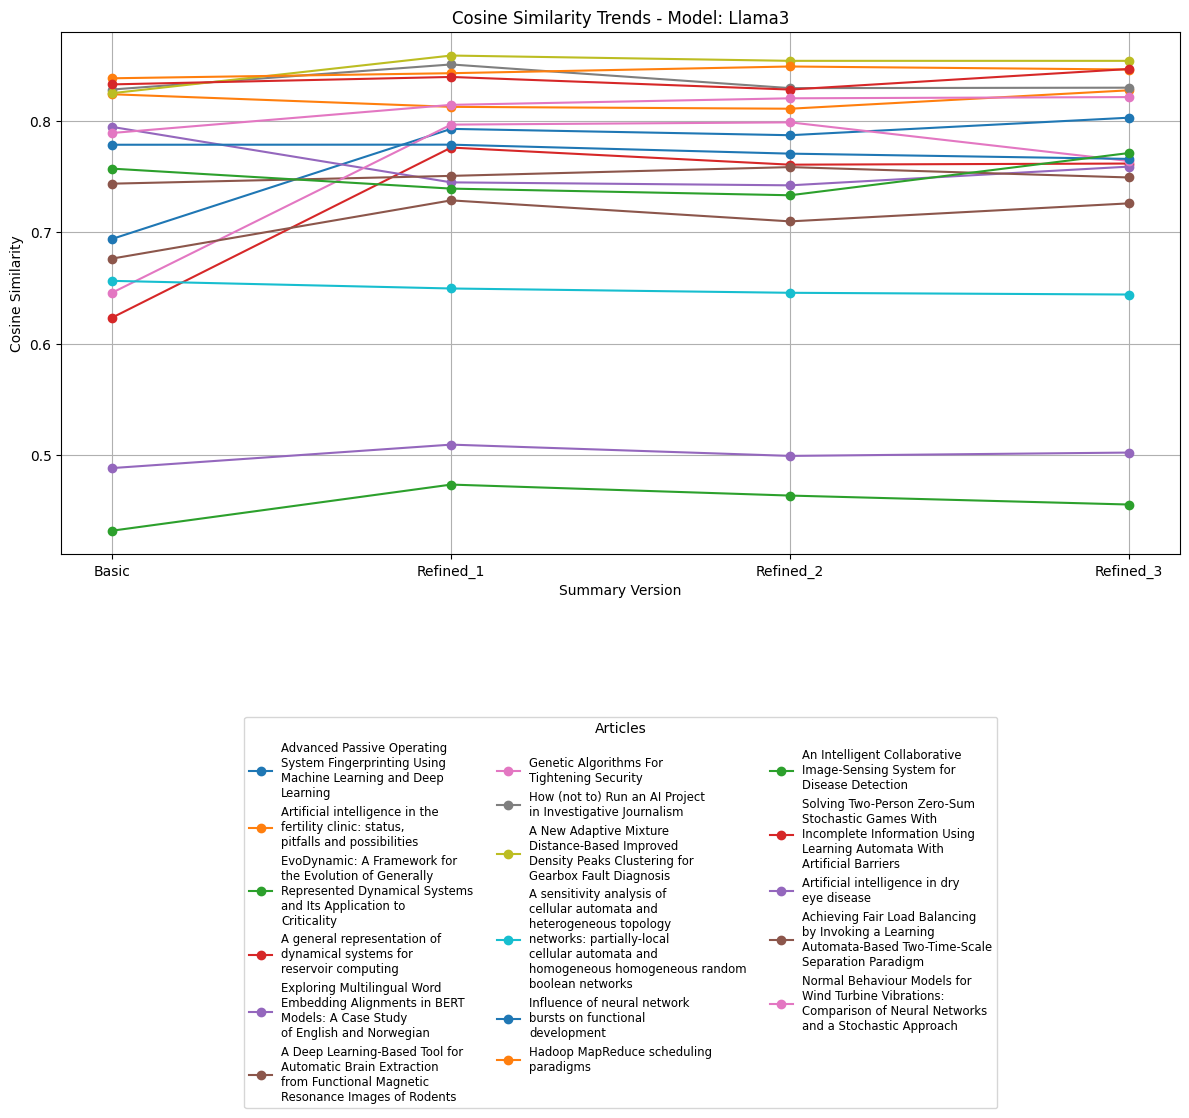


Example Summary Refinement for Model: Llama3
Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

Original Abstract:

—Securing and managing large, complex enterprise
network infrastructure requires capturing and analyzing network
trafﬁc traces in real-time. An accurate passive Operating System
(OS) ﬁngerprinting plays a critical role in effective network
management and cybersecurity protection. Passive ﬁngerprinting
doesn’t send probes that introduce extra load to the network and
hence it has a clear advantage over active ﬁngerprinting since
it also reduces the risk of triggering false alarms. This paper
proposes and evaluates an advanced classiﬁcation approach to
passive OS ﬁngerprinting by leveraging state-of-the-art classical
machine learning and deep learning techniques. Our controlled
experiments on benchmark data, emulated and realistic trafﬁc
is performed using two approaches. Through an Oracle-based
machine learning approach, we fo

In [31]:
# evaluate Llama3 with grid search, similarity trends, and example summary
run_evaluation_for_model(
    model_name="Llama3",
    example_article_id=0,
    max_iterations=3,
)


Running evaluation for model: Falcon3


tokenizer_config.json:   0%|          | 0.00/365k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.34G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/113 [00:00<?, ?B/s]


Evaluating with temperature=0.3, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.3, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.3, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.3, max_new_tokens=350, top_p=0.95 ...

Evaluating with temperature=0.4, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.4, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.4, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.4, max_new_tokens=350, top_p=0.95 ...

Evaluating with temperature=0.5, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.5, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.5, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.5, max_new_tokens=350, top_p=0.95 ...
Best Config for Falcon3: {'temperature': 0.3, 'max_new_tokens': 350.0, 'top_p': 0.9} - Avg Improvement: 0.0315


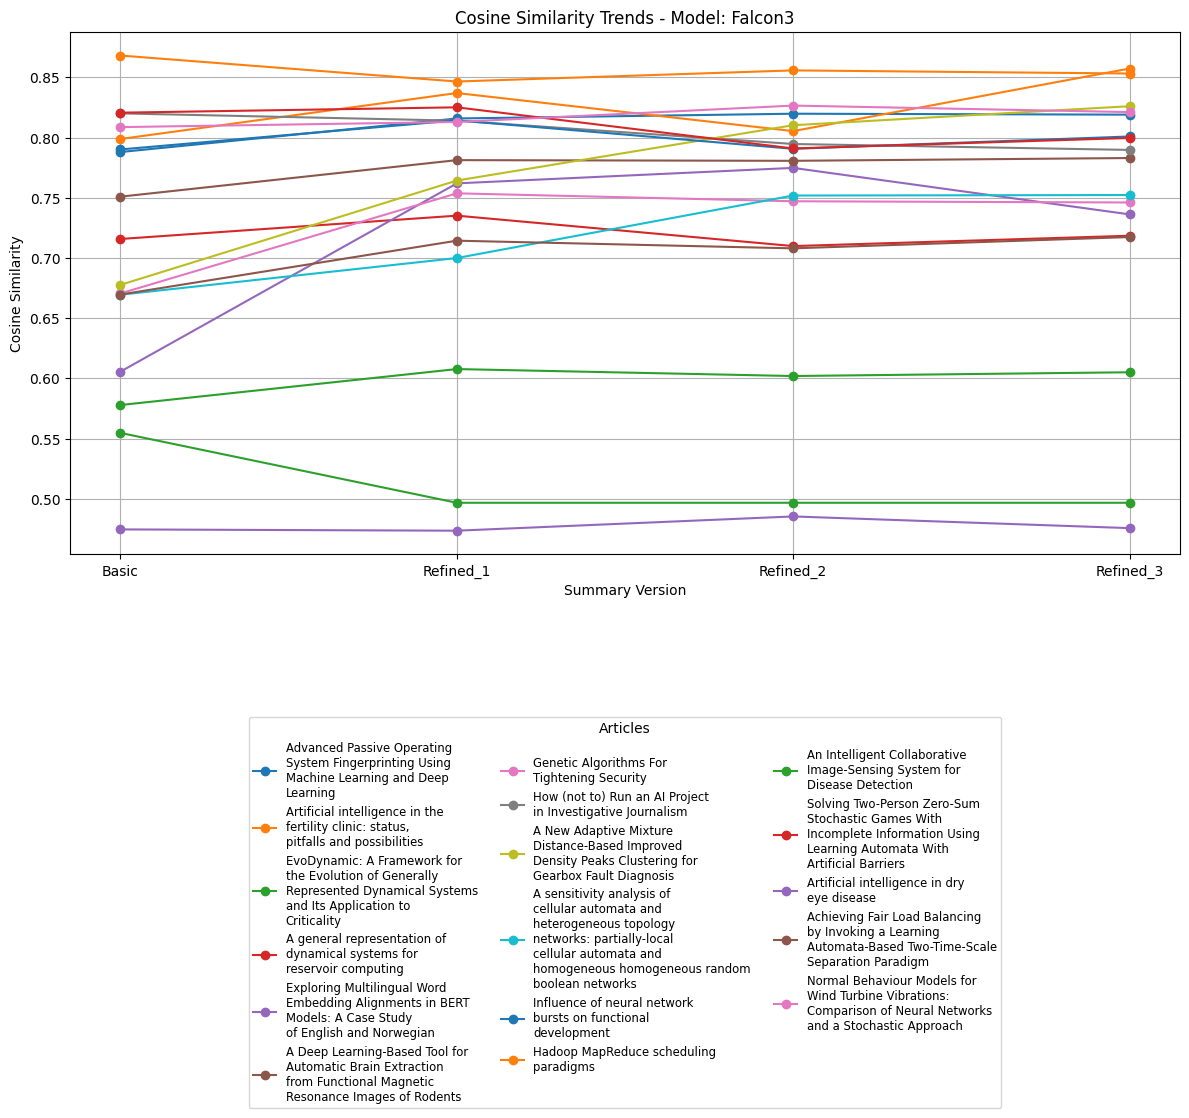


Example Summary Refinement for Model: Falcon3
Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

Original Abstract:

—Securing and managing large, complex enterprise
network infrastructure requires capturing and analyzing network
trafﬁc traces in real-time. An accurate passive Operating System
(OS) ﬁngerprinting plays a critical role in effective network
management and cybersecurity protection. Passive ﬁngerprinting
doesn’t send probes that introduce extra load to the network and
hence it has a clear advantage over active ﬁngerprinting since
it also reduces the risk of triggering false alarms. This paper
proposes and evaluates an advanced classiﬁcation approach to
passive OS ﬁngerprinting by leveraging state-of-the-art classical
machine learning and deep learning techniques. Our controlled
experiments on benchmark data, emulated and realistic trafﬁc
is performed using two approaches. Through an Oracle-based
machine learning approach, we f

In [32]:
# evaluate Falcon3 with grid search, similarity trends, and example summary
run_evaluation_for_model(
    model_name="Falcon3",
    example_article_id=0,
    max_iterations=3,
)


Running evaluation for model: Granite


tokenizer_config.json:   0%|          | 0.00/5.64k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.48M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]


Evaluating with temperature=0.3, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.3, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.3, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.3, max_new_tokens=350, top_p=0.95 ...

Evaluating with temperature=0.4, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.4, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.4, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.4, max_new_tokens=350, top_p=0.95 ...

Evaluating with temperature=0.5, max_new_tokens=250, top_p=0.9 ...

Evaluating with temperature=0.5, max_new_tokens=250, top_p=0.95 ...

Evaluating with temperature=0.5, max_new_tokens=350, top_p=0.9 ...

Evaluating with temperature=0.5, max_new_tokens=350, top_p=0.95 ...
Best Config for Granite: {'temperature': 0.4, 'max_new_tokens': 250.0, 'top_p': 0.9} - Avg Improvement: 0.0386


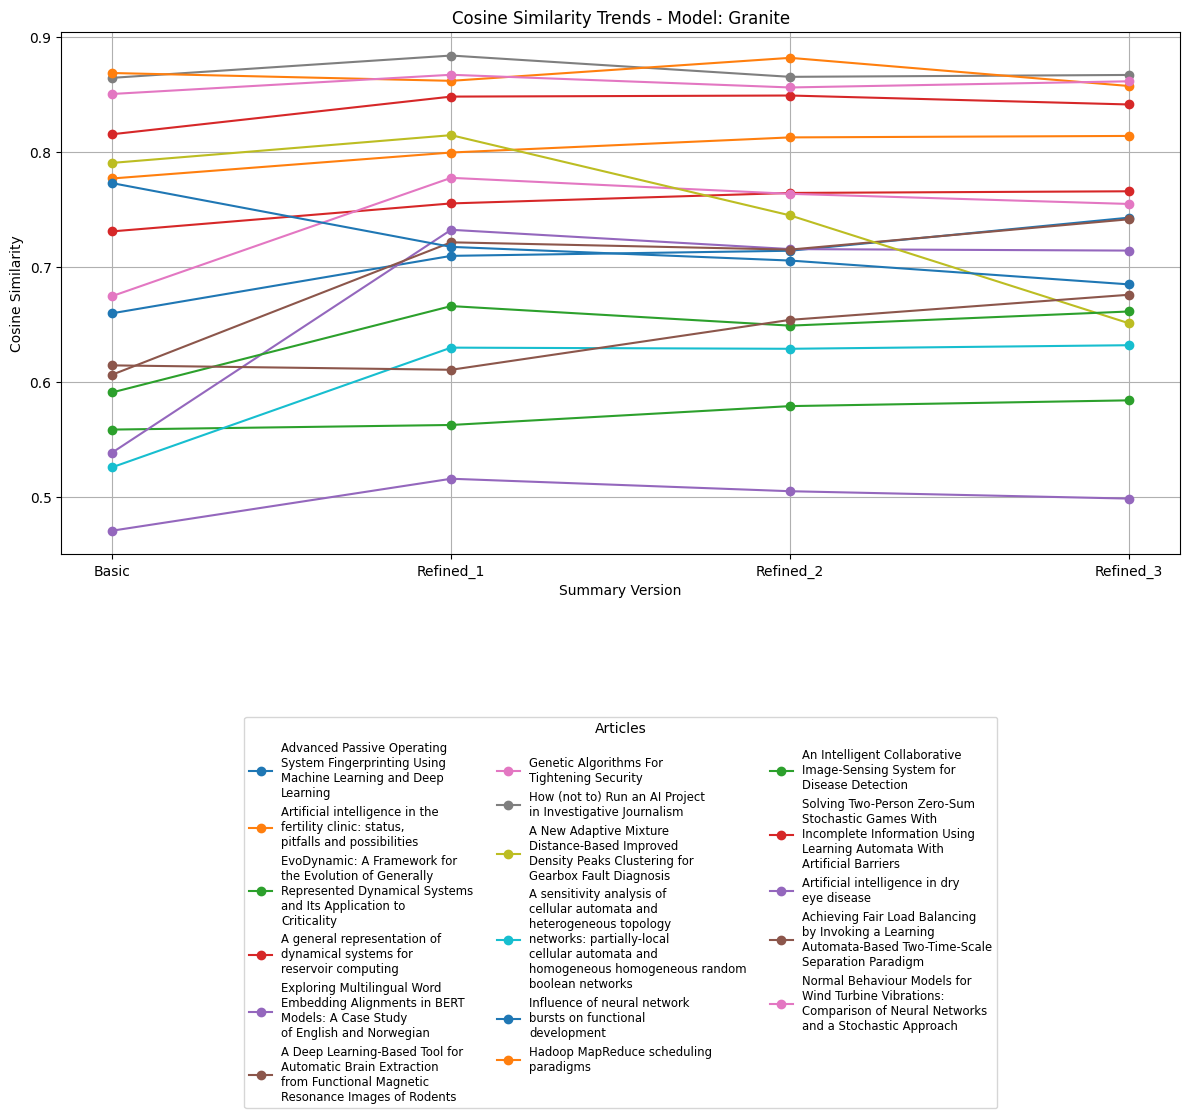


Example Summary Refinement for Model: Granite
Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

Original Abstract:

—Securing and managing large, complex enterprise
network infrastructure requires capturing and analyzing network
trafﬁc traces in real-time. An accurate passive Operating System
(OS) ﬁngerprinting plays a critical role in effective network
management and cybersecurity protection. Passive ﬁngerprinting
doesn’t send probes that introduce extra load to the network and
hence it has a clear advantage over active ﬁngerprinting since
it also reduces the risk of triggering false alarms. This paper
proposes and evaluates an advanced classiﬁcation approach to
passive OS ﬁngerprinting by leveraging state-of-the-art classical
machine learning and deep learning techniques. Our controlled
experiments on benchmark data, emulated and realistic trafﬁc
is performed using two approaches. Through an Oracle-based
machine learning approach, we f

In [31]:
# evaluate Granite with grid search, similarity trends, and example summary
run_evaluation_for_model(
    model_name="Granite",
    example_article_id=0,
    max_iterations=3,
)

### <a id="llm-significance"></a> 3.4) Statistical Significance Testing

To assess whether iterative refinement leads to statistically significant improvements, a Wilcoxon signed-rank test is performed for each model. The test compares cosine similarity scores before and after refinement. Results are reported along with average and median changes in similarity.

[⬆️ Back to Top](#top)

In [33]:
# Wilcoxon Signed-Rank Test for each model
for model_name, cosine_similarity_per_article in model_results.items():
    before_scores = []
    after_scores = []

    for data in cosine_similarity_per_article.values():

        # get before and after scores
        before = data["similarity_scores"][0]
        after = data["similarity_scores"][-1]
        before_scores.append(before)
        after_scores.append(after)

    # perform test
    if len(before_scores) >= 2:
        stat, p_value = wilcoxon(before_scores, after_scores, alternative='less')

        # print results for the model
        print("\n" + "=" * 50)
        print(f"Wilcoxon Signed-Rank Test (Refinement Improvement) - Model: {model_name}")
        print("=" * 50)
        print(f"Test Statistic: {stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("Statistically significant improvement after refinement (p < 0.05)")
        else:
            print("No statistically significant improvement (p ≥ 0.05)")
        print("=" * 50 + "\n")
    else:
        print(f"Not enough paired data for the Wilcoxon test in model {model_name}.")


Wilcoxon Signed-Rank Test (Refinement Improvement) - Model: Falcon3
Test Statistic: 31.0000
P-value: 0.0153
Statistically significant improvement after refinement (p < 0.05)



In [34]:
# print mean and median similarity scores with model name
print(f"\n=== Summary Statistics for Model: {model_name} ===")
print(f"Average similarity before refinement: {np.mean(before_scores):.4f}")
print(f"Average similarity after refinement:  {np.mean(after_scores):.4f}")
print(f"Median similarity before refinement:  {np.median(before_scores):.4f}")
print(f"Median similarity after refinement:   {np.median(after_scores):.4f}")


=== Summary Statistics for Model: Falcon3 ===
Average similarity before refinement: 0.7095
Average similarity after refinement:  0.7410
Median similarity before refinement:  0.7158
Median similarity after refinement:   0.7830


In [35]:
# print mean and median difference in similarity scores
differences = np.array(after_scores) - np.array(before_scores)
print(f"\n=== Cosine Similarity Differences for Model: {model_name} ===")
print(f"Differences in similarity scores: {differences}")
print(f"Mean difference: {np.mean(differences):.4f}")
print(f"Median difference: {np.median(differences):.4f}")


=== Cosine Similarity Differences for Model: Falcon3 ===
Differences in similarity scores: [ 0.03103536  0.05848467  0.02719146  0.00268215  0.13053483  0.03207171
  0.07548487 -0.03033268  0.14829469  0.08273035  0.01075411 -0.01492828
 -0.05798441 -0.02097958  0.00107366  0.04770911  0.01246333]
Mean difference: 0.0315
Median difference: 0.0272


<ipython-input-36-9d0969e39215>:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True)


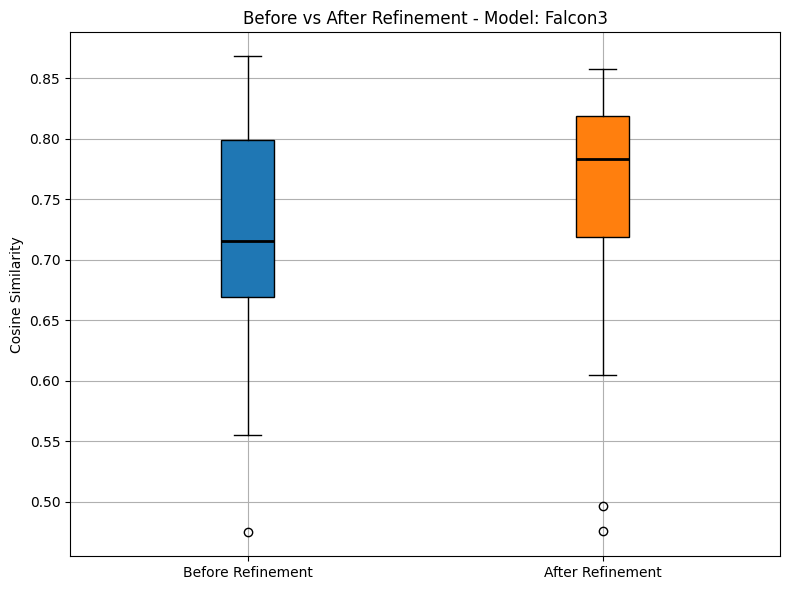

In [36]:
def plot_before_after_boxplot(model_name, before_scores, after_scores):
    """
    Plots a box plot comparing cosine similarity scores before and after refinement.

    Args:
        model_name: Name of the model used for generation.
        before_scores: Cosine similarity scores before refinement.
        after_scores: Cosine similarity scores after refinement.
    """

    # prepare data and corresponding labels
    data = [before_scores, after_scores]
    labels = ["Before Refinement", "After Refinement"]
    colors = ["C0", "C1"]

    plt.figure(figsize=(8, 6))
    box = plt.boxplot(data, labels=labels, patch_artist=True)

    # set box colors
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # style the median lines
    for median in box['medians']:
        median.set_color('black')
        median.set_linewidth(2)

    plt.ylabel("Cosine Similarity")
    plt.title(f"Before vs After Refinement - Model: {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_before_after_boxplot(model_name, before_scores, after_scores)

### <a id="shuffle"></a> 3.5) Control Study: Shuffled Abstracts

This section introduces a control experiment to evaluate the reliability of cosine similarity as a metric for summary faithfulness. It involves shuffling the abstracts in the dataset and comparing the LLM-generated summary of a given article with both its original abstract and a randomly assigned (shuffled) one. Cosine similarity is calculated in both cases to determine whether the similarity score meaningfully distinguishes between truly related content and unrelated content. A higher similarity with the original abstract and a lower similarity with the shuffled abstract would indicate that the evaluation metric can effectively capture semantic alignment.

[⬆️ Back to Top](#top)

In [36]:
# set up a text generation pipeline with custom parameters
llm_pipeline = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    return_full_text=False
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

# create a QA chain using retriever and LLM
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
)

In [37]:
def shuffle_abstracts(df):
    """
    Randomly shuffles the abstracts while keeping titles unchanged.

    Args:
        df: DataFrame containing an 'abstract' column.

    Returns:
        list: Shuffled list of abstracts.
    """

    # extract abstracts as a list
    shuffled_abstracts = df["abstract"].tolist()

    # shuffle abstracts in place
    random.shuffle(shuffled_abstracts)
    return shuffled_abstracts

In [38]:
def evaluate_shuffled_abstracts(article_id, df, retriever, qa_chain, sim_model):
    """
    Evaluates how faithful a generated summary is by comparing its cosine similarity
    to the correct abstract vs. a randomly shuffled one (control test).

    Args:
        article_id: Index of the article in the DataFrame.
        df: DataFrame with 'title' and 'abstract' columns.
        retriever: Document retriever for fetching relevant context.
        qa_chain: QA chain for generating summaries.
        sim_model: Sentence embedding model for computing cosine similarity.

    Returns:
        dict: Contains original/shuffled abstracts, summary, and similarity scores.
    """
    # extract article title and abstract
    article = df.iloc[article_id]
    original_abstract = article["abstract"]
    title = article["title"]

    # retrieve relevant documents
    retrieved_docs = retriever.invoke(title)
    if not retrieved_docs:
        return {
            "title": title,
            "original_abstract": original_abstract,
            "shuffled_abstract": None,
            "generated_summary": "No relevant documents found.",
            "Original Cosine Similarity": None,
            "Shuffled Cosine Similarity": None
        }

    # generate a summary using the QA chain
    query = f"Summarize the research article titled: {title}"
    response = qa_chain.invoke(input={"query": query, "documents": retrieved_docs})
    generated_summary = response.get('result', '').split('Answer:')[-1].strip()

    # select shuffled abstract (same index, random order)
    shuffled_abstracts = shuffle_abstracts(df)
    shuffled_abstract = shuffled_abstracts[article_id]

    # compute cosine similarity between summary and original abstract
    original_embeddings = sim_model.encode([original_abstract, generated_summary])
    original_similarity = cosine_similarity([original_embeddings[0]], [original_embeddings[1]])[0][0]

    # compute similarity between summary and shuffled abstract
    shuffled_embeddings = sim_model.encode([shuffled_abstract, generated_summary])
    shuffled_similarity = cosine_similarity([shuffled_embeddings[0]], [shuffled_embeddings[1]])[0][0]

    return {
        "title": title,
        "original_abstract": original_abstract,
        "shuffled_abstract": shuffled_abstract,
        "generated_summary": generated_summary,
        "Original Cosine Similarity": original_similarity,
        "Shuffled Cosine Similarity": shuffled_similarity
    }

In [39]:
# evaluate cosine similarity drop using shuffled abstracts for all articles
results = []

for article_id in df.index:
    result = evaluate_shuffled_abstracts(article_id, df, retriever, qa_chain, sim_model)
    results.append(result)

# print comparison of similarity scores
for result in results:
    print(f"Title: {result['title']}")
    print(f"Original Cosine Similarity: {result['Original Cosine Similarity']:.4f}")
    print(f"Shuffled Cosine Similarity: {result['Shuffled Cosine Similarity']:.4f}")
    print("=" * 50)


Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning
Original Cosine Similarity: 0.7606
Shuffled Cosine Similarity: 0.3249
Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities
Original Cosine Similarity: 0.8341
Shuffled Cosine Similarity: 0.1550
Title: EvoDynamic: A Framework for the Evolution of Generally Represented Dynamical Systems and Its Application to Criticality
Original Cosine Similarity: 0.0786
Shuffled Cosine Similarity: 0.1367
Title: A general representation of dynamical systems for reservoir computing
Original Cosine Similarity: 0.7953
Shuffled Cosine Similarity: 0.7953
Title: Exploring Multilingual Word Embedding Alignments in BERT Models: A Case Study of English and Norwegian
Original Cosine Similarity: 0.7134
Shuffled Cosine Similarity: 0.0665
Title: A Deep Learning-Based Tool for Automatic Brain Extraction from Functional Magnetic Resonance Images of Rodents
Original Cosine Similarity: 0.

In [40]:
# extract titles and similarity scores from results
titles = [r["title"] for r in results]
original_similarities = [r["Original Cosine Similarity"] for r in results]
shuffled_similarities = [r["Shuffled Cosine Similarity"] for r in results]

In [41]:
def wrap_title(title, max_words=5):
    """
    Helper function to wrap long titles for better readability in plots.
    """
    words = title.split()
    return "\n".join([" ".join(words[i:i+max_words]) for i in range(0, len(words), max_words)])

wrapped_titles = [wrap_title(t) for t in titles]

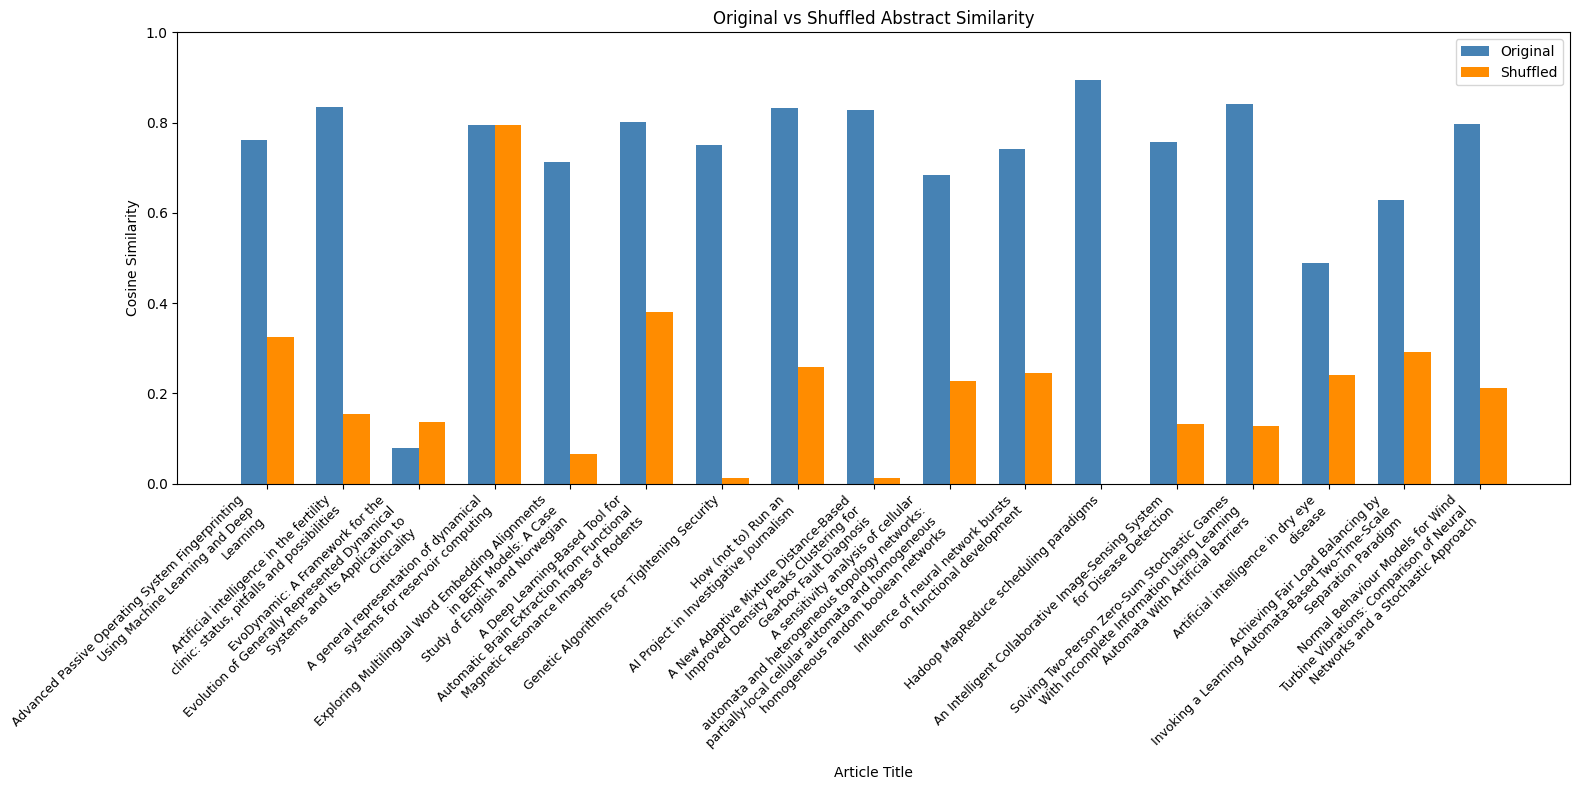

In [42]:
x = np.arange(len(titles))
width = 0.35

# bar plot comparing original vs shuffled abstract similarity scores
plt.figure(figsize=(16, 8))
plt.bar(x - width/2, original_similarities, width, label='Original', color='steelblue')
plt.bar(x + width/2, shuffled_similarities, width, label='Shuffled', color='darkorange')

plt.xlabel('Article Title')
plt.ylabel('Cosine Similarity')
plt.title('Original vs Shuffled Abstract Similarity')
plt.xticks(ticks=x, labels=wrapped_titles, rotation=45, ha='right', fontsize=9)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

## <a id="hallucination"></a> 4) Hallucination Detection

### <a id="sentence-processing"></a> 4.1) Sentence Processing

This section defines a utility function to segment generated summaries into individual sentences, preparing them for sentence-level hallucination analysis. The function uses regular expressions to split text based on common punctuation marks that signal sentence boundaries (such as periods, exclamation marks, and question marks). Each resulting sentence is cleaned by stripping surrounding whitespace. This preprocessing step enables a more granular analysis of semantic similarity and factual grounding by treating each sentence as a separate unit for evaluation.

[⬆️ Back to Top](#top)

In [43]:
def sentence_splitting(text):
    """
    Splits a text string into individual sentences using punctuation-based boundaries.

    Args:
        text: The input text to split.

    Returns:
        list: List of cleaned sentences with leading/trailing whitespace removed.
    """
    return [s.strip() for s in re.split(r'(?<=[.!?]) +', text) if s.strip()]

### <a id="similarities"></a> 4.2) Compute Sentence Similarities and Thresholds

This section defines functions to compute sentence-level semantic similarities and estimate thresholds for hallucination detection. The `sentence_cosine_similarity` function takes two lists of sentences—from a generated summary and a reference article—and encodes them using a shared embedding model. It then computes a matrix of pairwise cosine similarity scores, providing a detailed view of how well each summary sentence aligns with the article content.

To detect hallucinated sentences, the `compute_similarity_thresholds` function estimates thresholds for different similarity metrics (e.g., mean, max, min) using kernel density estimation (KDE). The core idea is to identify a natural separation point between grounded and ungrounded content by locating the first valley in the KDE curve of similarity values. If no valley is found, the function falls back to using the 25th percentile. This adaptive thresholding technique is useful for identifying potentially hallucinated sentences.

[⬆️ Back to Top](#top)

In [44]:
def sentence_cosine_similarity(sentences1, sentences2, model):
    """
    Computes the pairwise cosine similarity between two lists of sentences using embeddings.

    Args:
        sentences1: First list of sentences.
        sentences2: Second list of sentences.
        model: Model used to encode sentences into embeddings.

    Returns:
        np.ndarray: A 2D array of cosine similarity scores between sentence pairs.
    """
    embeddings1 = model.encode(sentences1, convert_to_tensor=True).cpu()
    embeddings2 = model.encode(sentences2, convert_to_tensor=True).cpu()
    return cosine_similarity(embeddings1, embeddings2)

In [45]:
def find_kde_valley_threshold(similarities):
    """
    Estimate a threshold from similarity scores using the first local minimum
    of the kernel density estimate (KDE). Falls back to the 25th percentile
    if no local minimum is found.

    Parameters:
        similarities: List or array of similarity scores.

    Returns:
        float: Estimated similarity threshold.
    """
    # return min if one value, 0.0 if empty
    if len(similarities) < 2:
        return np.min(similarities) if len(similarities) == 1 else 0.0

    # fit KDE over the similarity values
    kde = gaussian_kde(similarities)

    # generate smooth range of values across the similarity span
    x = np.linspace(min(similarities), max(similarities), 1000)

    # evaluate KDE at these points
    y = kde(x)

    # find indices of local minima in the KDE curve
    minima_indices = argrelextrema(y, np.less)[0]

    # if no local minima are found, fall back to a fixed percentile
    if len(minima_indices) == 0:
        return np.percentile(similarities, 25)

    return x[minima_indices[0]]

In [46]:
def compute_similarity_thresholds(similarities_dict):
    """
    Compute KDE-based similarity thresholds for multiple types of similarity scores
    (mean, max, min). Uses the first valley in the KDE curve to identify
    a separation point between likely factual and hallucinatory content.

    Args:
        similarities_dict: A dictionary where each key is a similarity type and the value is a list or array of similarity scores.

    Returns:
        dict: A dictionary with the same keys as the input, mapping each to its corresponding computed threshold.
    """
    thresholds = {}

    # iterate over each type of similarity score
    for name, sims in similarities_dict.items():
        sims_arr = np.array(sims)

        # if no scores available, set threshold to 0.0
        if len(sims_arr) == 0:
            thresholds[name] = 0.0

        # use KDE to find a threshold based on valley in distribution
        else:
            threshold = find_kde_valley_threshold(sims_arr)
            thresholds[name] = threshold

            # log the computed threshold
            print(f"KDE-based threshold for {name}: {threshold:.4f}")

    return thresholds

### <a id="identify-hallucinations"></a> 4.3) Detect Hallucinations in Model-Generated Summaries

This section implements a sentence-level hallucination detection method based on semantic similarity between each summary sentence and the source article. The `identify_hallucinations` function evaluates the mean, max, and min cosine similarity for each summary sentence against all article sentences and flags those that fall below KDE-based thresholds as potential hallucinations. Sentences that fall below both the mean and max thresholds are flagged more strictly, offering a higher-confidence hallucination signal.

The `detect_hallucinations` function uses this process for each article. It first generates summary versions using the summarization pipeline, splits both summaries and source articles into sentences, and encodes them into embeddings. It computes all pairwise cosine similarity scores between the summaries and the article text, then derives KDE-based thresholds to separate grounded from ungrounded content.

To support interpretability and evaluation, the code includes visualizations comparing similarity score distributions for both generated summaries and original abstracts. It also prints hallucinated summary sentences alongside their closest matching article sentences, providing concrete examples of factual divergence.

[⬆️ Back to Top](#top)

In [47]:
def identify_hallucinations(similarities, summary_sentences, article_sentences, thresholds, level):
    """
    Flags potentially hallucinated summary sentences based on similarity thresholds.
    For each summary sentence, checks if mean, max, or min similarity to article
    sentences falls below thresholds. Also flags those failing both mean and max.

    Args:
        similarities: 2D array of similarity scores (summary × article).
        summary_sentences: List of summary sentences.
        article_sentences: List of article sentences.
        thresholds: Dict with "mean", "max", and "min" thresholds.
        level: Summary refinement level.

    Returns:
        tuple: Lists of hallucinations by mean, max, min, and both thresholds.
    """
    mean_h, max_h, min_h, both_h = [], [], [], []
    for idx, sim_scores in enumerate(similarities):

        # compute summary-to-article similarity statistics
        mean_sim = np.mean(sim_scores)
        max_sim = np.max(sim_scores)
        min_sim = np.min(sim_scores)

        # retrieve the most similar article sentence for context
        most_similar_sentence = article_sentences[np.argmax(sim_scores)]
        sentence = summary_sentences[idx]

        # check if similarity falls below thresholds and flag accordingly
        if mean_sim < thresholds["mean"]:
            mean_h.append({"level": level, "summary_sentence": sentence, "similarity_score": mean_sim, "article_sentence": most_similar_sentence})
        if max_sim < thresholds["max"]:
            max_h.append({"level": level, "summary_sentence": sentence, "similarity_score": max_sim, "article_sentence": most_similar_sentence})
        if min_sim < thresholds["min"]:
            min_h.append({"level": level, "summary_sentence": sentence, "similarity_score": min_sim, "article_sentence": most_similar_sentence})
        if mean_sim < thresholds["mean"] and max_sim < thresholds["max"]:
            both_h.append({"level": level, "summary_sentence": sentence, "mean_similarity_score": mean_sim, "max_similarity_score": max_sim, "article_sentence": most_similar_sentence})

    return mean_h, max_h, min_h, both_h

In [48]:
def detect_hallucinations(article_id, df, retriever, qa_chain, sim_model):
    """
    Detect hallucinated summary sentences by comparing them to article content
    using cosine similarity and KDE-based thresholds.

    Args:
        article_id: Index of the article in the DataFrame.
        df: DataFrame containing article data.
        retriever: Document retriever for context.
        qa_chain: Summarization or QA pipeline.
        sim_model: Sentence embedding model.

    Returns:
        tuple: Article title, four hallucination lists (mean, max, min, both),
               and a dict of similarity scores.
    """
    # generate summaries and retrieve relevant documents
    summary_data = abstract_summary_comparison(article_id, df, retriever, qa_chain)
    article = df.iloc[article_id]
    article_title = article["title"]
    article_text = article["cleaned_content"]
    article_abstract = article["abstract"]

    if not summary_data["retrieved_docs"]:
        return article_title, [], [], [], [], {"mean": [], "max": [], "min": []}

    # split article into sentences and compute embeddings
    article_sentences = sentence_splitting(article_text)
    article_embeddings = sim_model.encode(article_sentences, convert_to_tensor=True).cpu()

    all_sims = {"mean": [], "max": [], "min": []}
    level_sims = {}
    all_flattened_summary_similarities = []

    # compute similarities for each summary level
    for level, summary in summary_data["generated_summaries"].items():
        summary_sentences = sentence_splitting(summary)
        summary_embeddings = sim_model.encode(summary_sentences, convert_to_tensor=True).cpu()
        sims = cosine_similarity(summary_embeddings, article_embeddings)

        level_sims[level] = (summary_sentences, sims)
        all_sims["mean"].extend(np.mean(sims, axis=1))
        all_sims["max"].extend(np.max(sims, axis=1))
        all_sims["min"].extend(np.min(sims, axis=1))
        all_flattened_summary_similarities.append(sims.flatten())

    # compute thresholds using KDE-based valley detection
    thresholds = compute_similarity_thresholds(all_sims)

    # plot similarity distribution for generated summaries
    if all_flattened_summary_similarities:
        all_flattened_summary_similarities = np.concatenate(all_flattened_summary_similarities)
        plt.figure(figsize=(8,5))
        sns.histplot(all_flattened_summary_similarities, bins=30, kde=True, color="blue", edgecolor="black", alpha=0.7)
        plt.axvline(thresholds["mean"], color='red', linestyle='dashed', linewidth=2, label=f'Mean Threshold: {thresholds["mean"]:.2f}')
        plt.axvline(thresholds["max"], color='orange', linestyle='dashed', linewidth=2, label=f'Max Threshold: {thresholds["max"]:.2f}')
        plt.axvline(thresholds["min"], color='green', linestyle='dashed', linewidth=2, label=f'Min Threshold: {thresholds["min"]:.2f}')
        plt.xlabel("Cosine Similarity")
        plt.ylabel("Frequency")
        plt.title(f"Generated Summary vs Full Article (Article ID {article_id})")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    # compare original abstract to full article for reference
    abstract_sentences = sentence_splitting(article_abstract)
    abstract_embeddings = sim_model.encode(abstract_sentences, convert_to_tensor=True).cpu()
    sims_abstract = cosine_similarity(abstract_embeddings, article_embeddings)

    # flatten and compute KDE thresholds for abstract similarities
    abstract_sim_scores = {
      "mean": np.mean(sims_abstract, axis=1),
      "max": np.max(sims_abstract, axis=1),
      "min": np.min(sims_abstract, axis=1),
    }
    abstract_thresholds = compute_similarity_thresholds(abstract_sim_scores)

    # plot similarity distribution for abstract
    all_flattened_abstract_similarities = sims_abstract.flatten()
    plt.figure(figsize=(8,5))
    sns.histplot(all_flattened_abstract_similarities, bins=30, kde=True, color="green", edgecolor="black", alpha=0.7)
    plt.axvline(abstract_thresholds["mean"], color='red', linestyle='dashed', linewidth=2, label=f'Mean Threshold: {abstract_thresholds["mean"]:.2f}')
    plt.axvline(abstract_thresholds["max"], color='orange', linestyle='dashed', linewidth=2, label=f'Max Threshold: {abstract_thresholds["max"]:.2f}')
    plt.axvline(abstract_thresholds["min"], color='green', linestyle='dashed', linewidth=2, label=f'Min Threshold: {abstract_thresholds["min"]:.2f}')
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title(f"Original Abstract vs Full Article (Article ID {article_id})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # run hallucination detection per summary level
    hallucinations_mean, hallucinations_max, hallucinations_min, hallucinations_both = [], [], [], []
    for level, (summary_sentences, sims) in level_sims.items():
        mean_h, max_h, min_h, both_h = identify_hallucinations(sims, summary_sentences, article_sentences, thresholds, level)
        hallucinations_mean.extend(mean_h)
        hallucinations_max.extend(max_h)
        hallucinations_min.extend(min_h)
        hallucinations_both.extend(both_h)

    sim_scores_dict = {
        "mean": [h["similarity_score"] for h in hallucinations_mean],
        "max": [h["similarity_score"] for h in hallucinations_max],
        "min": [h["similarity_score"] for h in hallucinations_min]
    }

    return article_title, hallucinations_mean, hallucinations_max, hallucinations_min, hallucinations_both, sim_scores_dict, thresholds

In [49]:
def print_hallucinations(title, data, sim_key="similarity_score"):
    """
    Print detected hallucinated summary sentences with similarity scores
    and their most similar article sentence.

    Args:
        title: Label for the type of hallucination.
        data: List of hallucination entries to display.
        sim_key: Key used to extract the similarity score.
    """
    if data:
        print(f"\nDetected Hallucinations ({title}):")

        # print details for each hallucinated sentence
        for h in data:
            print(f"Level: {h['level']}")
            print(f"Summary Sentence: {h['summary_sentence']}")
            print(f"Similarity Score: {h.get(sim_key, 0):.4f}")
            print(f"Most Similar Article Sentence: {h['article_sentence']}\n" + "-" * 50)
    else:
        print(f"\nNo hallucinations detected based on {title.lower()}.")

### <a id="multi-article-detection"></a> 4.4) Multi-Article Detection

This section applies hallucination detection across the full dataset of research articles. For each article, summary sentences are analyzed using cosine similarity and flagged as hallucinated if they fall below KDE-derived thresholds. The `detect_hallucinations_multiple` function aggregates results for all articles. For each article, detected hallucinations are printed and grouped by detection strategy, alongside their similarity scores and most similar source sentence. Summary-level statistics are recorded in a structured data frame, capturing both hallucination counts and the similarity thresholds used for detection. In addition, similarity scores from all articles are aggregated to assess overall trends.

[⬆️ Back to Top](#top)

In [50]:
def detect_hallucinations_multiple(article_ids, df, retriever, qa_chain, sim_model):
    """
    Detect hallucinations across multiple articles and return summary stats.

    Args:
        article_ids: List of article indices.
        df: DataFrame with article content.
        retriever: Context retriever.
        qa_chain: Summary or QA pipeline.
        sim_model: Embedding model.

    Returns:
        tuple: stats_df, results, and combined similarity scores.
    """
    results = []
    stats = []
    all_sims_list = []
    for article_id in article_ids:
        try:
            # detect hallucinations for the current article
            article_title, halluc_mean, halluc_max, halluc_min, halluc_both, sim_scores_dict, thresholds = detect_hallucinations(
            article_id, df, retriever, qa_chain, sim_model
            )

            print(f"\nArticle Title: {article_title}\n" + "=" * 50)
            print_hallucinations("Mean Similarity", halluc_mean)
            print_hallucinations("Max Similarity", halluc_max)
            print_hallucinations("Min Similarity", halluc_min)

            # print hallucinations failing both mean and max thresholds
            if halluc_both:
                print("\nDetected Hallucinations: Both Mean and Max Similarity:")
                for h in halluc_both:
                    print(f"Level: {h['level']}")
                    print(f"Mean Similarity Score: {h['mean_similarity_score']:.4f}")
                    print(f"Max Similarity Score: {h['max_similarity_score']:.4f}")
                    print(f"Summary Sentence: {h['summary_sentence']}")
                    print(f"Most Similar Article Sentence: {h['article_sentence']}\n" + "-" * 50)
            else:
                print("\nNo hallucinations detected for both thresholds.")

            # store full hallucination data
            results.append({
                "article_id": article_id,
                "article_title": article_title,
                "hallucinations_mean": halluc_mean,
                "hallucinations_max": halluc_max,
                "hallucinations_min": halluc_min,
                "hallucinations_both": halluc_both,
            })

            # store summary statistics
            stats.append({
                "article_id": article_id,
                "article_title": article_title,
                "mean_count": len(halluc_mean),
                "max_count": len(halluc_max),
                "min_count": len(halluc_min),
                "both_count": len(halluc_both),
                "mean_threshold": thresholds["mean"],
                "max_threshold": thresholds["max"],
                "min_threshold": thresholds["min"]
            })
            all_sims_list.append(sim_scores_dict)

        except Exception as e:
            print(f"\nError processing article ID {article_id}: {e}")
            continue

    # combine all per-article similarity scores
    stats_df = pd.DataFrame(stats)
    combined_similarities = {
        "mean": np.concatenate([sims["mean"] for sims in all_sims_list if sims["mean"]]) if any(sims["mean"] for sims in all_sims_list) else np.array([]),
        "max": np.concatenate([sims["max"] for sims in all_sims_list if sims["max"]]) if any(sims["max"] for sims in all_sims_list) else np.array([]),
        "min": np.concatenate([sims["min"] for sims in all_sims_list if sims["min"]]) if any(sims["min"] for sims in all_sims_list) else np.array([])
    }

    return stats_df, results, combined_similarities

In [51]:
# set up a text generation pipeline with custom parameters
llm_pipeline = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    return_full_text=False
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

# create a QA chain using retriever and LLM
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
)

KDE-based threshold for mean: 0.1880
KDE-based threshold for max: 0.7110
KDE-based threshold for min: -0.0876


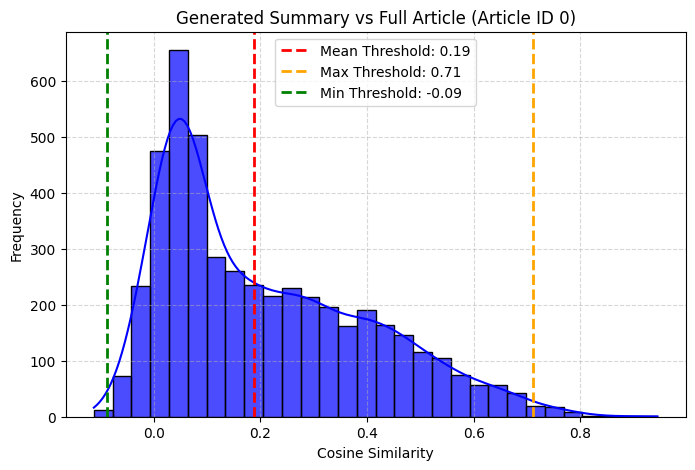

KDE-based threshold for mean: 0.2073
KDE-based threshold for max: 0.8284
KDE-based threshold for min: -0.0915


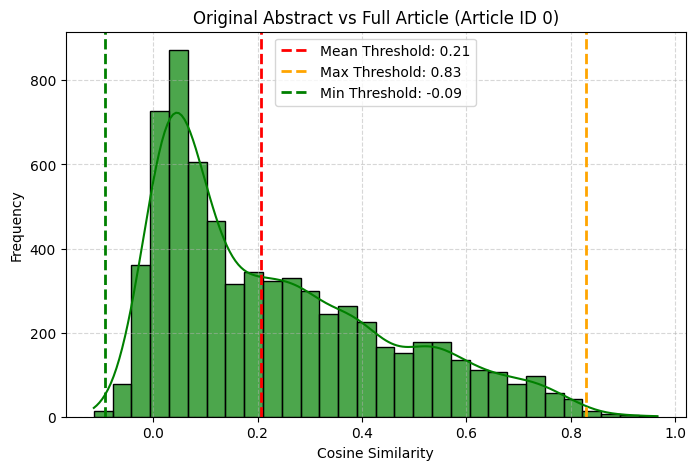


Article Title: Advanced Passive Operating System Fingerprinting Using Machine Learning and Deep Learning

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: This research article is about developing a tool that can detect the operating system of a computer without using any external information.
Similarity Score: 0.1776
Most Similar Article Sentence: The second approach we used to identify the OS is getting the predeﬁned browser strings that loosely tell the name of the underlying OS assigned by the vendor from Webserver.
--------------------------------------------------
Level: basic
Summary Sentence: This tool can help identify the operating system of a computer without revealing any sensitive information.
Similarity Score: 0.1826
Most Similar Article Sentence: Using techniques like this, some remote computers announce their underlying OS freely and running application services with their versions in use to anyone connecting to them as part of welcome banners 

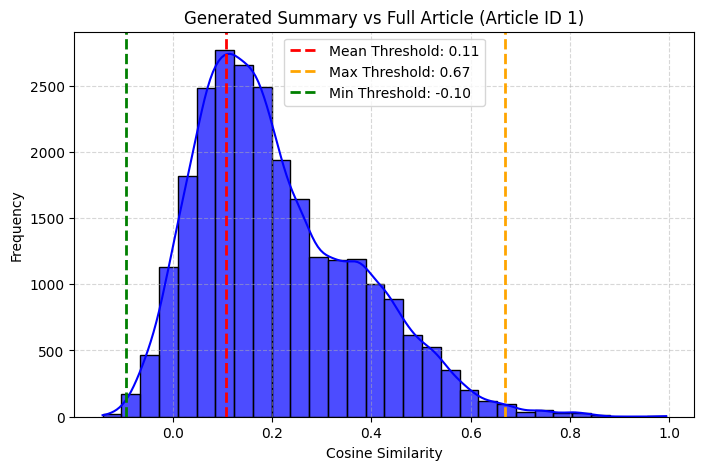

KDE-based threshold for mean: 0.1244
KDE-based threshold for max: 0.6241
KDE-based threshold for min: -0.1116


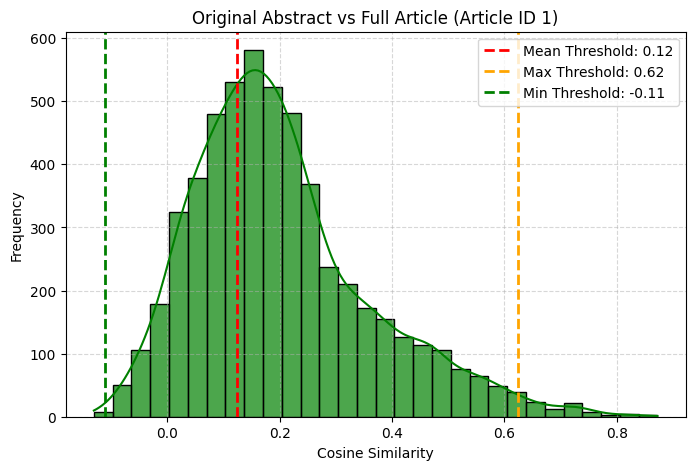


Article Title: Artificial intelligence in the fertility clinic: status, pitfalls and possibilities

Detected Hallucinations (Mean Similarity):
Level: specialized
Summary Sentence: (2020).
Similarity Score: 0.0788
Most Similar Article Sentence: 2020 Ilhan et al.
--------------------------------------------------
Level: specialized
Summary Sentence: (2020).
Similarity Score: 0.0788
Most Similar Article Sentence: 2020 Ilhan et al.
--------------------------------------------------
Level: specialized
Summary Sentence: (2020).
Similarity Score: 0.0788
Most Similar Article Sentence: 2020 Ilhan et al.
--------------------------------------------------
Level: specialized
Summary Sentence: (2020).
Similarity Score: 0.0788
Most Similar Article Sentence: 2020 Ilhan et al.
--------------------------------------------------
Level: specialized
Summary Sentence: (2020).
Similarity Score: 0.0788
Most Similar Article Sentence: 2020 Ilhan et al.
--------------------------------------------------
Level:

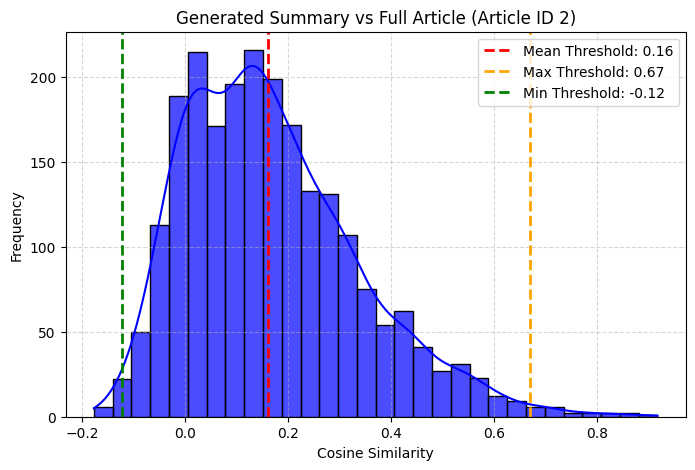

KDE-based threshold for mean: 0.1758
KDE-based threshold for max: 0.3530
KDE-based threshold for min: -0.1503


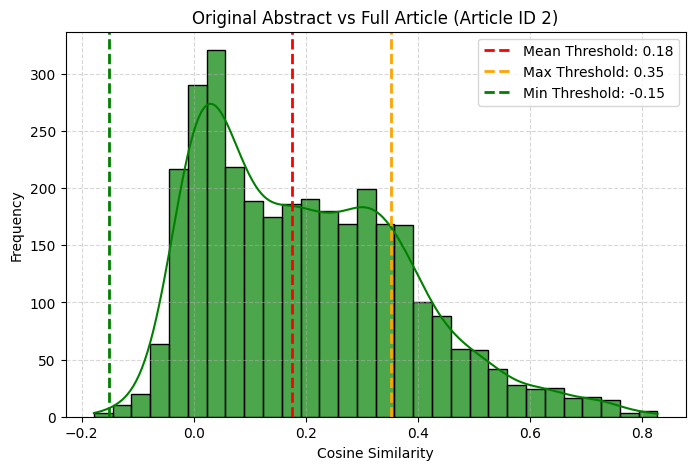


Article Title: EvoDynamic: A Framework for the Evolution of Generally Represented Dynamical Systems and Its Application to Criticality

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: It's used to understand how these systems can change over time, especially in relation to criticality.
Similarity Score: 0.1540
Most Similar Article Sentence: Another characteristic of a dynamical system, which is crucial for computation, is to be in a critical state, Table 1: Examples of dynamical systems.
--------------------------------------------------
Level: basic
Summary Sentence: In simpler terms, EvoDynamic is a tool that helps scientists analyze and understand how complex systems evolve and can become more "critical" or unstable.
Similarity Score: 0.1086
Most Similar Article Sentence: Section 4 discusses the initial advances and future plan of EvoDynamic framework and Section 5 concludes this paper.
--------------------------------------------------

Detected Hallucina

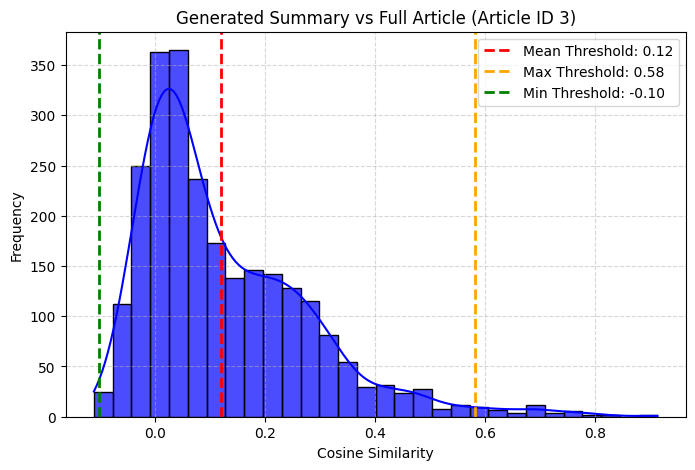

KDE-based threshold for mean: 0.1749
KDE-based threshold for max: 0.6417
KDE-based threshold for min: -0.1219


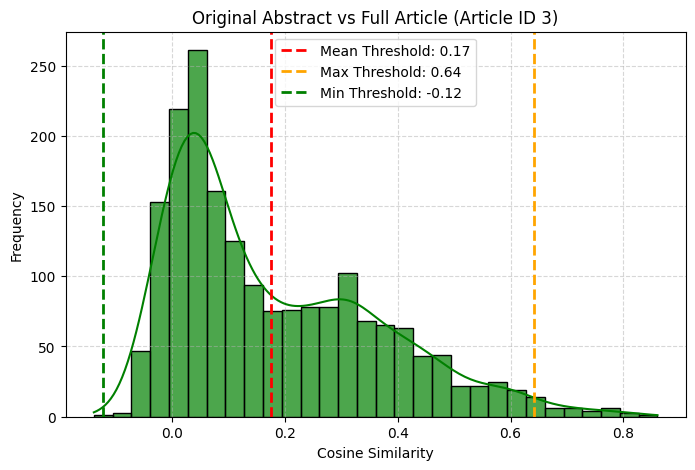


Article Title: A general representation of dynamical systems for reservoir computing

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: It's based on the idea of using a simple computer that can learn and adapt to new data, rather than trying to solve a problem from scratch.
Similarity Score: 0.1070
Most Similar Article Sentence: Wolfram, A new kind of science.
--------------------------------------------------
Level: basic
Summary Sentence: This could be a game-changer for fields like medicine and finance, where complex data needs to be processed quickly and accurately.
Similarity Score: 0.1001
Most Similar Article Sentence: Therefore, it beneﬁts from powerful and parallel computing systems with multi-CPU and multi-GPU.
--------------------------------------------------

Detected Hallucinations (Max Similarity):
Level: basic
Summary Sentence: It's based on the idea of using a simple computer that can learn and adapt to new data, rather than trying to solve a p

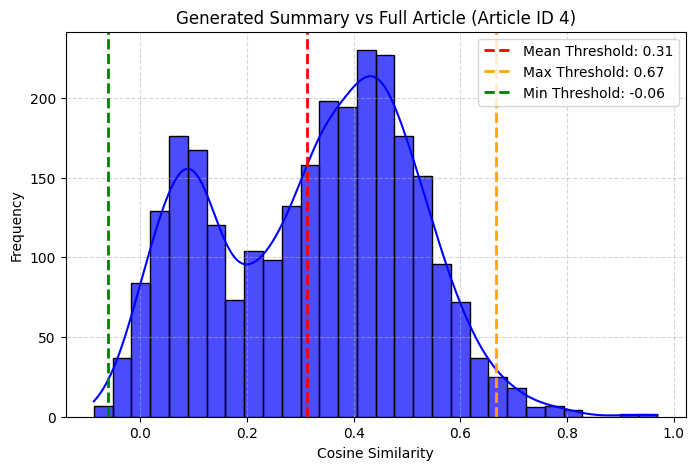

KDE-based threshold for mean: 0.2612
KDE-based threshold for max: 0.7202
KDE-based threshold for min: -0.0619


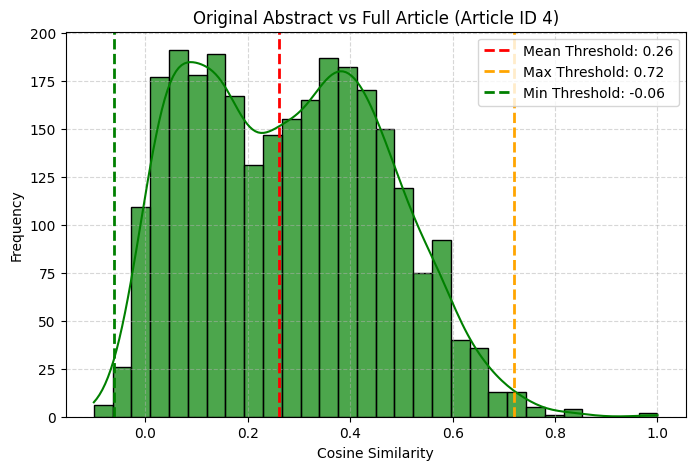


Article Title: Exploring Multilingual Word Embedding Alignments in BERT Models: A Case Study of English and Norwegian

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: The study looks at how these models work with English and Norwegian texts.
Similarity Score: 0.3107
Most Similar Article Sentence: Consequently, monolingual Norwegian language models will likely not achieve the same performance as monolingual English language models.
--------------------------------------------------
Level: basic
Summary Sentence: To do this, the researchers used a technique called multilingual word embedding, which involves training the model on a dataset that includes both English and Norwegian texts.
Similarity Score: 0.3110
Most Similar Article Sentence: Norwegian is a language that borrows many words and phrases from English.
--------------------------------------------------
Level: basic
Summary Sentence: They then used this model to analyze the similarities between words 

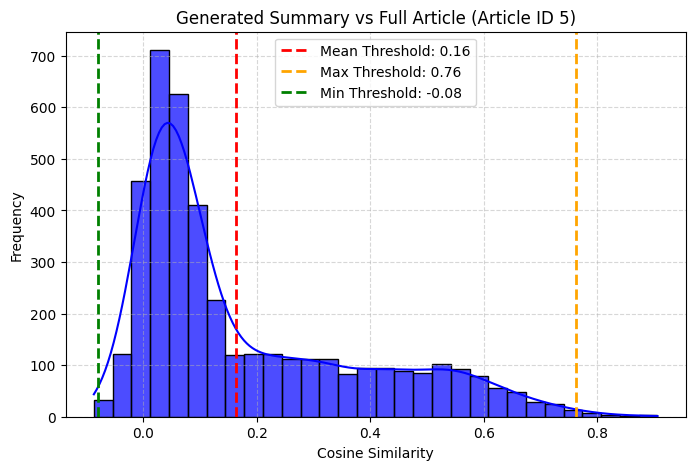

KDE-based threshold for mean: 0.1626
KDE-based threshold for max: 0.7506
KDE-based threshold for min: -0.0618


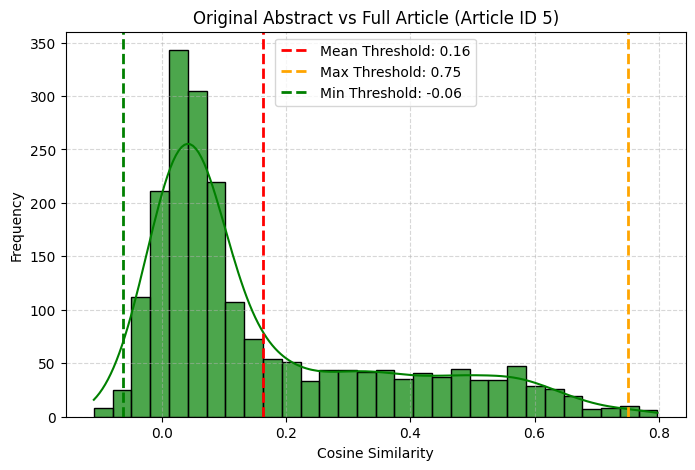


Article Title: A Deep Learning-Based Tool for Automatic Brain Extraction from Functional Magnetic Resonance Images of Rodents

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: A new deep learning-based tool has been developed to improve the accuracy of brain extraction.
Similarity Score: 0.1509
Most Similar Article Sentence: To overcome this obstacle, we have developed a deep learning-based tool in Python that quickly and successfully extracts the brain from the functional datasets, thus improving the speed and accuracy of the preprocessing pipeline.
--------------------------------------------------
Level: basic
Summary Sentence: The tool is designed to work with rodent brains, which have unique characteristics that make them more difficult to extract.
Similarity Score: 0.1549
Most Similar Article Sentence: This means that the automated tools developed to handle human data such as Brain Extraction Toolkit (BET) [8] and BrainSuites Brain Surface Extractor (BSE

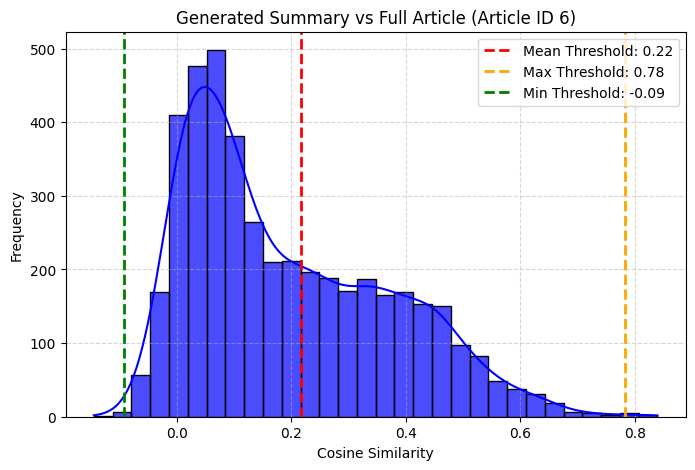

KDE-based threshold for mean: 0.1847
KDE-based threshold for max: 0.6797
KDE-based threshold for min: -0.0821


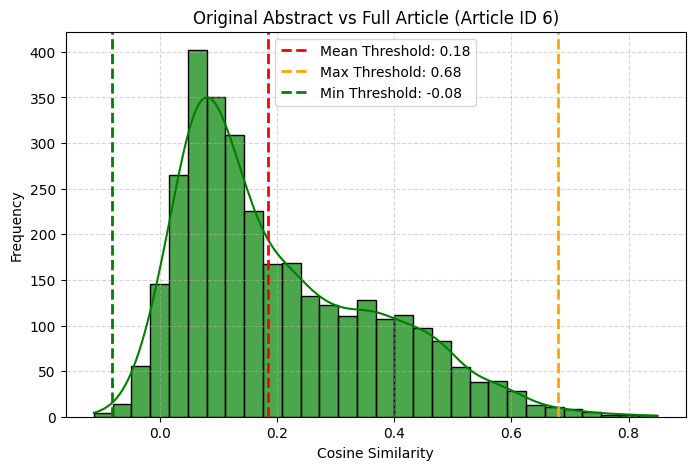


Article Title: Genetic Algorithms For Tightening Security

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: The algorithm uses a technique called genetic search, which is like a computer's natural selection process.
Similarity Score: 0.1681
Most Similar Article Sentence: The genetic algorithm discovers better parameter settings for the attacked parameters in each generation.
--------------------------------------------------
Level: basic
Summary Sentence: The algorithm tries out many different combinations of settings and chooses the best one based on the results.
Similarity Score: 0.1714
Most Similar Article Sentence: After receiving all the scores, the algorithm selects the n ﬁttest solutions for further mating.
--------------------------------------------------
Level: basic
Summary Sentence: This helps to create a more secure computer system by finding the best way to protect it from cyber threats.
Similarity Score: 0.1862
Most Similar Article Sentence: Som

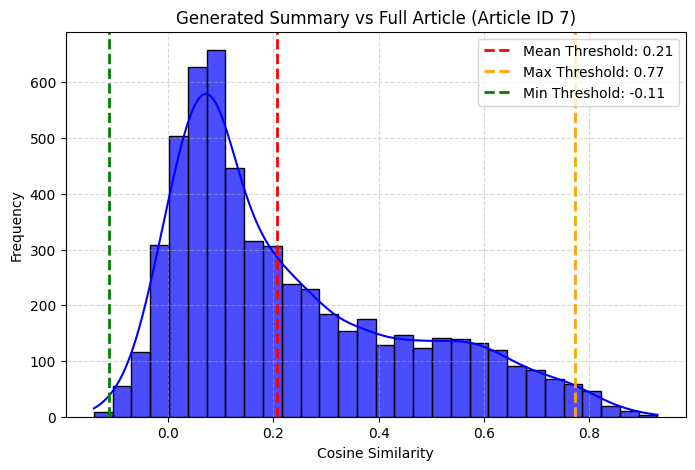

KDE-based threshold for mean: 0.1960
KDE-based threshold for max: 0.8192
KDE-based threshold for min: -0.0894


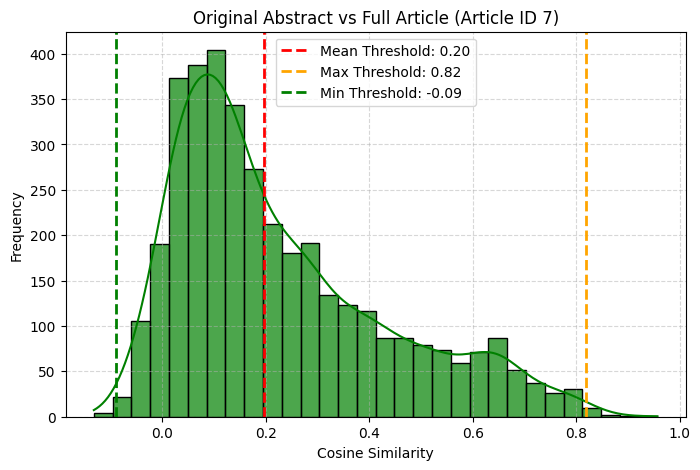


Article Title: How (not to) Run an AI Project in Investigative Journalism

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: Another method is to use AI to automate repetitive tasks, such as data cleaning and organization, freeing up time for journalists to focus on more complex and in-depth investigations.
Similarity Score: 0.1879
Most Similar Article Sentence: In this context, computers can play a central role in automating repetitive and computationally intensive processes, enabling journalists to extract information that would otherwise be inaccess- ible (Beckett 2019).
--------------------------------------------------

Detected Hallucinations (Max Similarity):
Level: basic
Summary Sentence: One approach is to use AI-powered tools that can help analyze large datasets, identify patterns, and provide insights that human journalists may miss.
Similarity Score: 0.7498
Most Similar Article Sentence: Data jour- nalists are now more reliant on automation and AI t

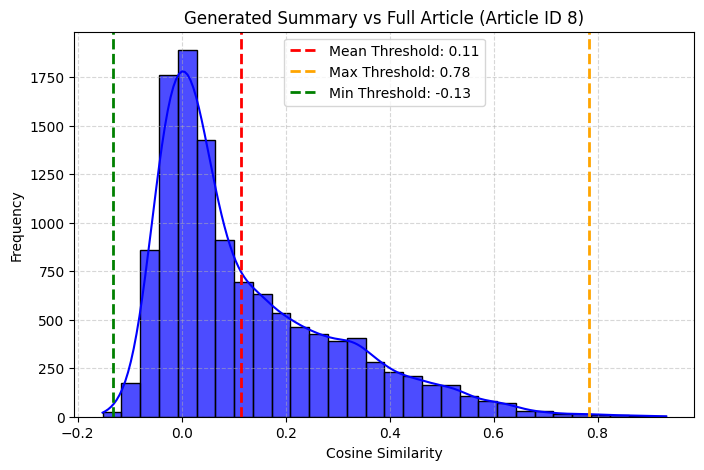

KDE-based threshold for mean: 0.1068
KDE-based threshold for max: 0.6176
KDE-based threshold for min: -0.1089


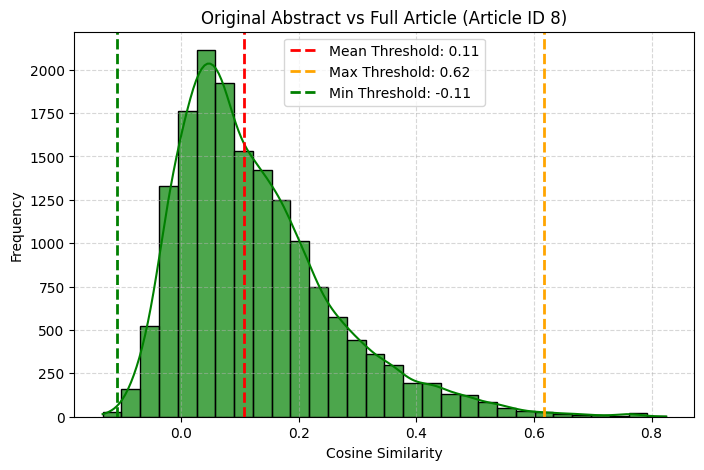


Article Title: A New Adaptive Mixture Distance-Based Improved Density Peaks Clustering for Gearbox Fault Diagnosis

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: A new approach has been developed to improve the accuracy of diagnosing gearbox faults.
Similarity Score: 0.0761
Most Similar Article Sentence: Therefore, the proposed study is an effective method for gearbox fault diagnosis.
--------------------------------------------------
Level: specialized
Summary Sentence: The study demonstrates the effectiveness of MDPC-AD in diagnosing gearbox faults and shows that the proposed method is able to achieve the lowest value of zero clustering error.
Similarity Score: 0.1119
Most Similar Article Sentence: CONCLUSION This study introduces the DPC-based clustering technique named MDPC-AD for gearbox fault diagnostics.
--------------------------------------------------
Level: specialized
Summary Sentence: The authors conclude that MDPC-AD is a promising method for 

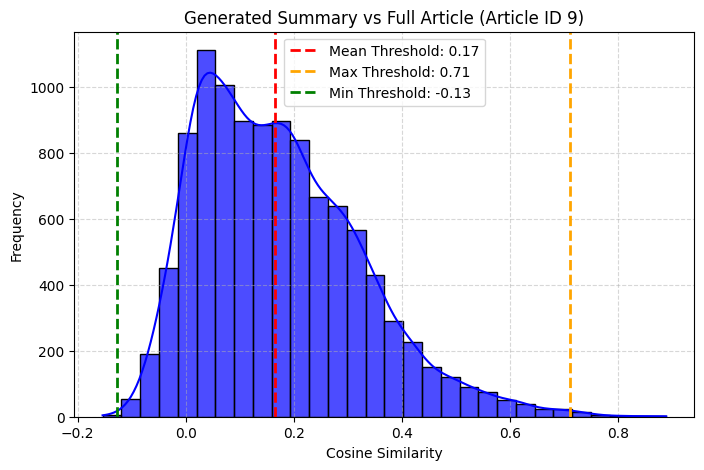

KDE-based threshold for mean: 0.1488
KDE-based threshold for max: 0.6801
KDE-based threshold for min: -0.1328


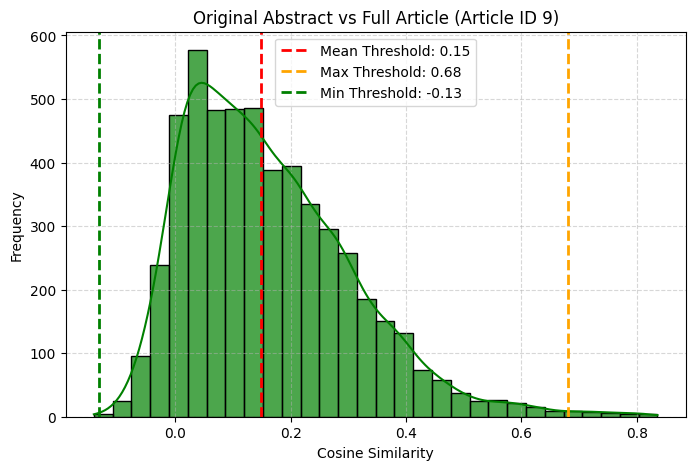


Article Title: A sensitivity analysis of cellular automata and heterogeneous topology networks: partially-local cellular automata and homogeneous homogeneous random boolean networks

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: The research article, titled "A sensitivity analysis of cellular automata and heterogeneous topology networks: partially-local cellular automata and homogeneous homogeneous random boolean networks," examines how the characteristics of different types of networks affect the behavior of cellular automata, which are simple computational models that simulate the behavior of complex systems.

The study, published in the International Journal of Parallel, Emergent and Distributed Systems, found that the characteristics of the networks, such as the size and structure of the network, can significantly impact the behavior of the cellular automata.
Similarity Score: 0.1581
Most Similar Article Sentence: International Journal of Parallel, Emer

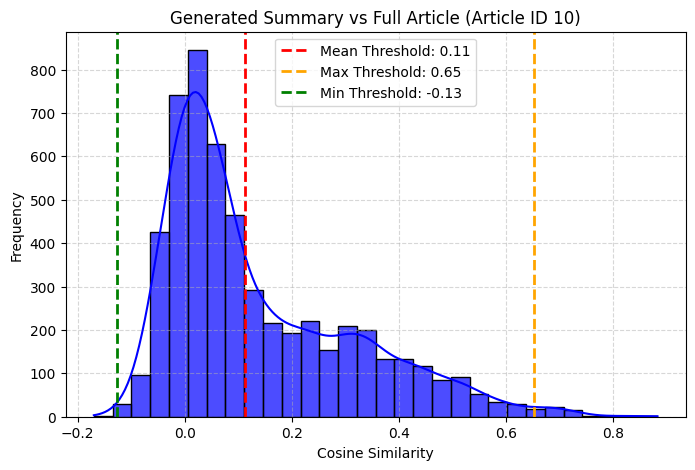

KDE-based threshold for mean: 0.1499
KDE-based threshold for max: 0.7546
KDE-based threshold for min: -0.1187


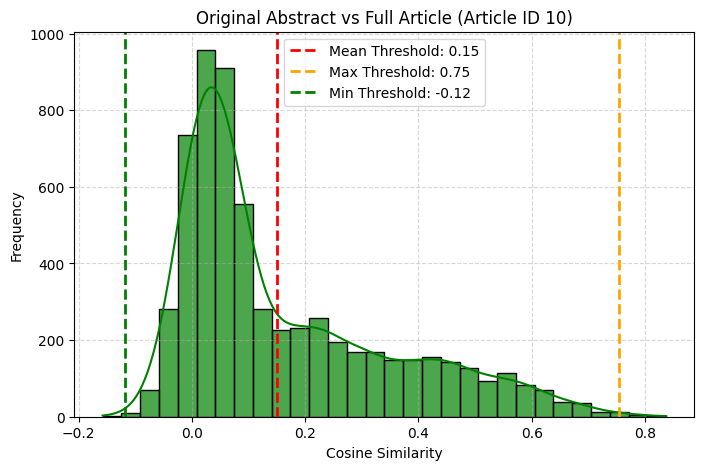


Article Title: Influence of neural network bursts on functional development

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: Neural networks in the lab can get stuck in a state where they don't grow or change, which is called a "developmental plateau".
Similarity Score: 0.0807
Most Similar Article Sentence: Thus, the network burst persistence likely represents a form of arrested development, though the cause of this developmental plateau is still unknown.
--------------------------------------------------
Level: basic
Summary Sentence: This is not because the networks themselves are failing, but because the external inputs to the lab, such as changes in the environment, are not providing enough stimulation to keep the networks active.
Similarity Score: 0.1025
Most Similar Article Sentence: This prevalence of network bursting can thus dominate the activity of the in vitro network, pushing out more varied and complex activity [22]–[24], and in turn reduce its i

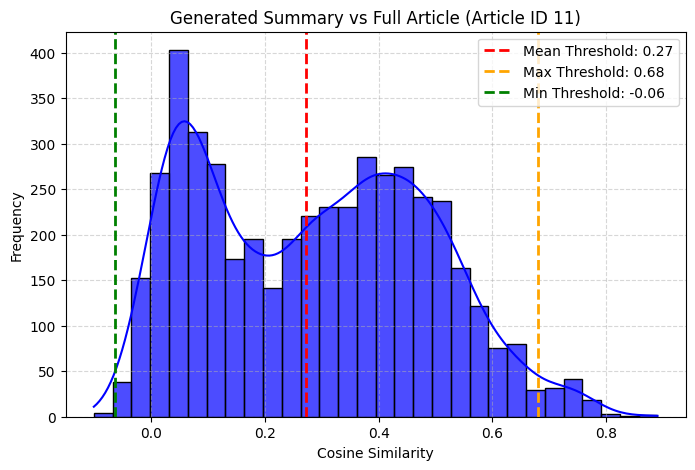

KDE-based threshold for mean: 0.2573
KDE-based threshold for max: 0.7774
KDE-based threshold for min: -0.0252


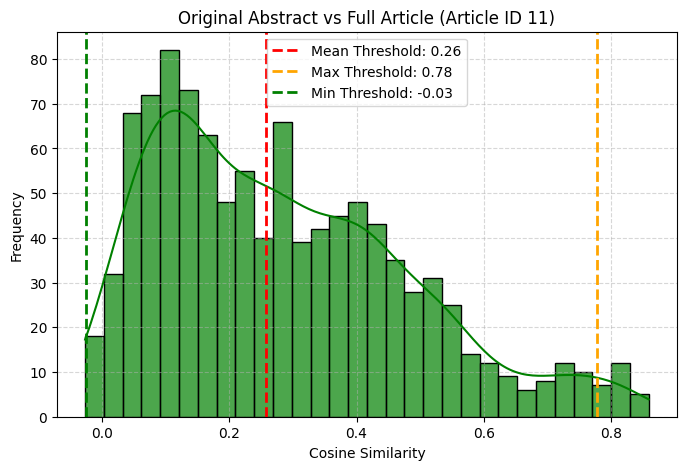


Article Title: Hadoop MapReduce scheduling paradigms

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: Big websites generate huge amounts of data every day, and it can take hours to process this data.
Similarity Score: 0.1993
Most Similar Article Sentence: INTRODUCTION Bollier stated, "Big websites can generate terabytes of raw log data every day.
--------------------------------------------------
Level: basic
Summary Sentence: To manage this large amount of data, the data center needs to have a system to process it efficiently.
Similarity Score: 0.2612
Most Similar Article Sentence: In the same time, it brings along the challenge of handling extreme amounts of data.
--------------------------------------------------
Level: basic
Summary Sentence: MapReduce is one of the systems that can help achieve this.
Similarity Score: 0.2180
Most Similar Article Sentence: The challenges represented by big data handling can be divided into three groups: • Velocity • Volum

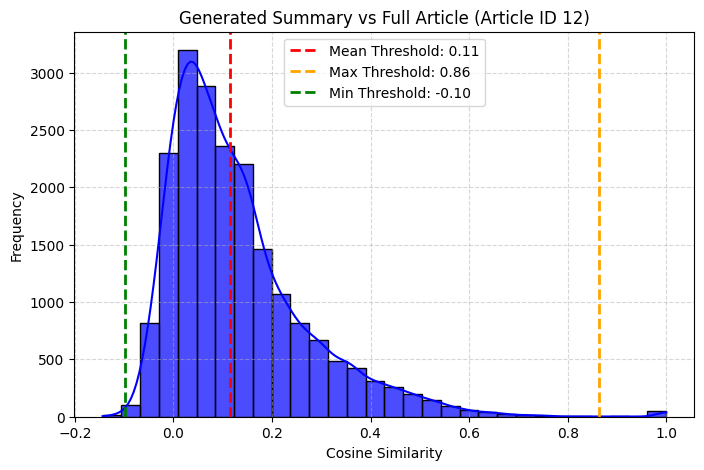

KDE-based threshold for mean: 0.1197
KDE-based threshold for max: 0.6958
KDE-based threshold for min: -0.0884


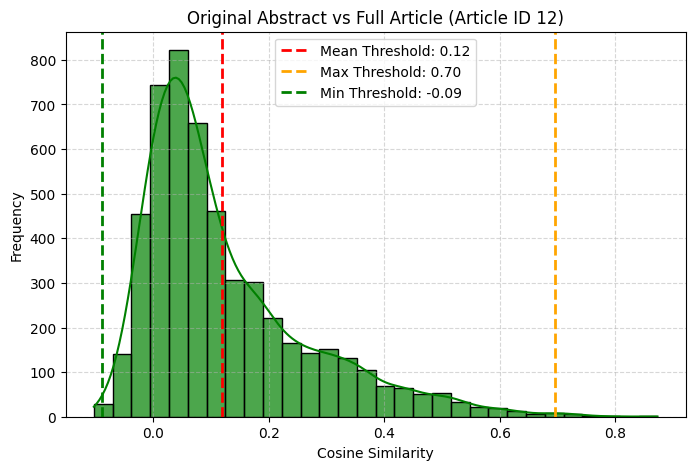


Article Title: An Intelligent Collaborative Image-Sensing System for Disease Detection

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: The system has shown promise in detecting esophageal cancer, a type of cancer that affects the esophagus.
Similarity Score: 0.0873
Most Similar Article Sentence: The aim is to automate the detection of endoscopic ﬁndings in the esophagus, stomach, intestines, and rectum.
--------------------------------------------------
Level: basic
Summary Sentence: The system is being used to train doctors to make more accurate diagnoses, which could lead to better patient outcomes.
Similarity Score: 0.1142
Most Similar Article Sentence: This enables signiﬁcant determination of various diseases in healthcare systems.
--------------------------------------------------
Level: specialized
Summary Sentence: DJENOURI et al.: INTELLIGENT COLLABORATIVE IMAGE-SENSING SYSTEM FOR DISEASE DETECTION 951 Fig.
Similarity Score: 0.1071
Most Similar Artic

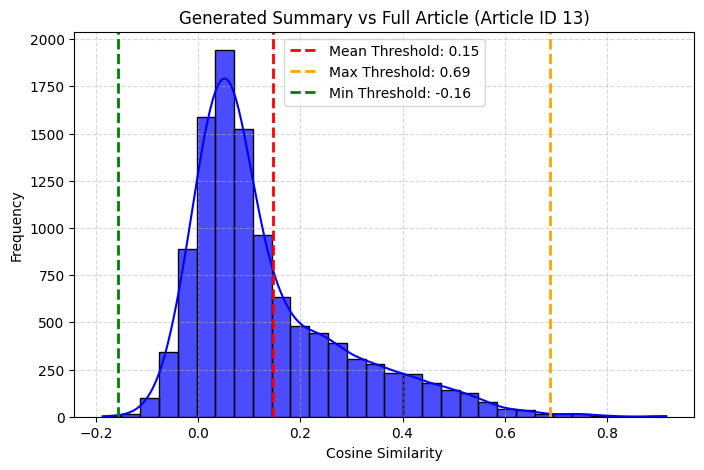

KDE-based threshold for mean: 0.1071
KDE-based threshold for max: 0.5767
KDE-based threshold for min: -0.1353


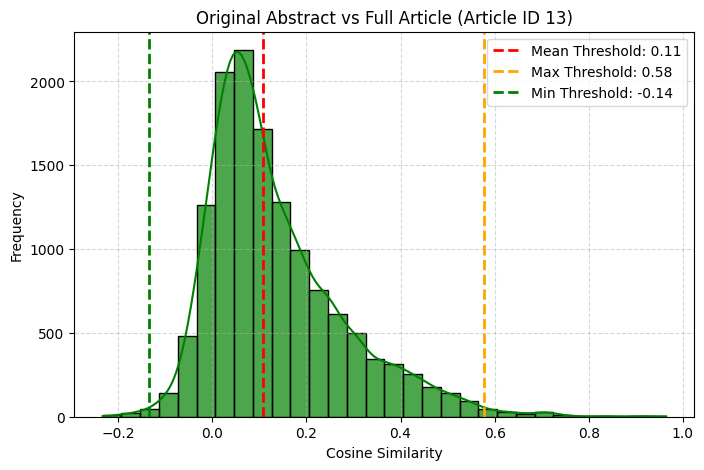


Article Title: Solving Two-Person Zero-Sum Stochastic Games With Incomplete Information Using Learning Automata With Artificial Barriers

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: In a zero-sum game, two players make decisions that result in a net outcome of zero for one player but non-zero for the other.
Similarity Score: 0.1304
Most Similar Article Sentence: Since the game is zero-sum, the outcomes are either a loss for player A, with reward −1, and the corresponding win for player B with value +1, or the converse for the case of a win for player A.
--------------------------------------------------
Level: basic
Summary Sentence: Incomplete information refers to the lack of complete knowledge about the opponent's actions.
Similarity Score: 0.1188
Most Similar Article Sentence: Incomplete infor- mation is a taxonomy used within the ﬁeld of LA games to denote the case where the players do not observe the action of the opponent players and where each pla

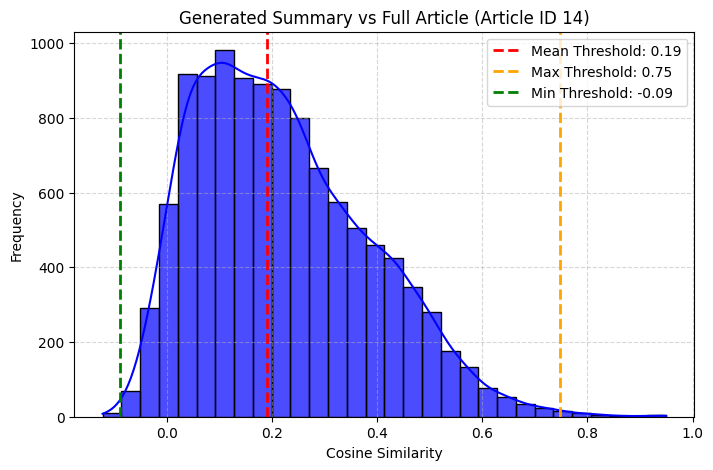

KDE-based threshold for mean: 0.1663
KDE-based threshold for max: 0.6957
KDE-based threshold for min: -0.0984


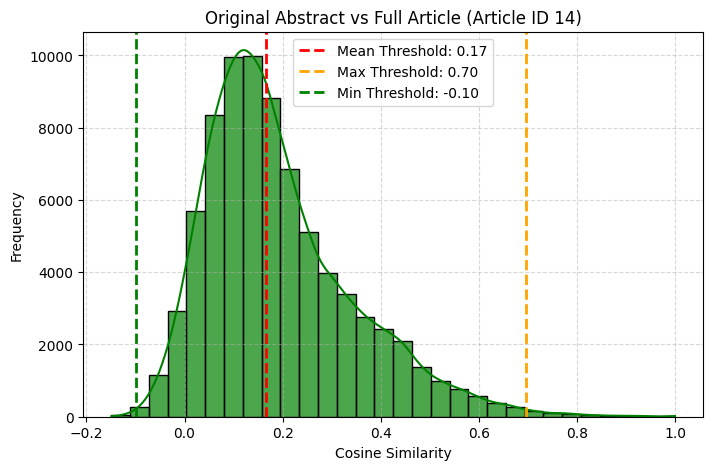


Article Title: Artificial intelligence in dry eye disease

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: Dry eye disease is a common condition that affects millions of people worldwide.
Similarity Score: 0.1679
Most Similar Article Sentence: Introduction Dry eye disease (DED) is one of the most common eye diseases worldwide, with a prevalence of between 5 and 50%, depending on the diagnostic criteria used and study population [1].
--------------------------------------------------
Level: basic
Summary Sentence: It occurs when the eyes do not produce enough tears, leading to dryness and irritation.
Similarity Score: 0.1489
Most Similar Article Sentence: Tear osmolarity Tear osmolarity is a measure of tear concentration, and high values can indicate dry eyes.
--------------------------------------------------
Level: specialized
Summary Sentence: It found 111 relevant studies, with 45 remaining after removing duplicates.
Similarity Score: 0.1640
Most Similar A

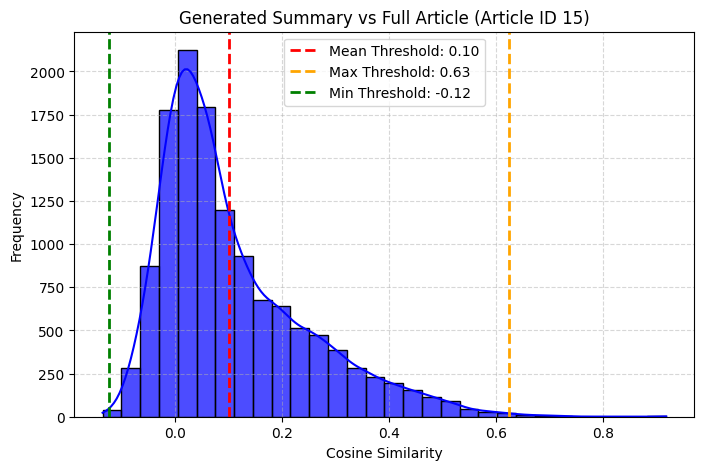

KDE-based threshold for mean: 0.1184
KDE-based threshold for max: 0.6263
KDE-based threshold for min: -0.1073


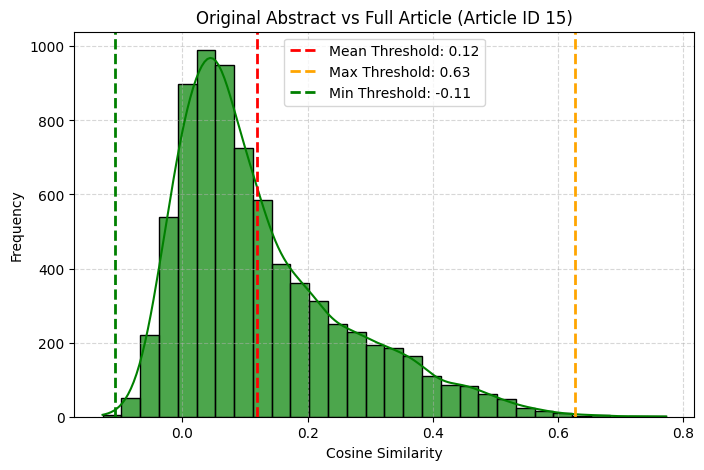


Article Title: Achieving Fair Load Balancing by Invoking a Learning Automata-Based Two-Time-Scale Separation Paradigm

Detected Hallucinations (Mean Similarity):
Level: specialized
Summary Sentence: The authors propose a learning automata-based algorithm that learns the optimal separation points between the two time scales and optimizes the load distribution accordingly.

The algorithm uses a combination of machine learning techniques, including neural networks and reinforcement learning, to learn the optimal separation points.
Similarity Score: 0.0797
Most Similar Article Sentence: 8, AUGUST 2021 Achieving Fair Load Balancing by Invoking a Learning Automata-Based Two-Time-Scale Separation Paradigm Anis Yazidi , Senior Member, IEEE, Ismail Hassan, Hugo L.
--------------------------------------------------
Level: specialized
Summary Sentence: The authors also introduce an artificial barrier mechanism to prevent the algorithm from converging to a suboptimal solution.
Similarity Score: 0

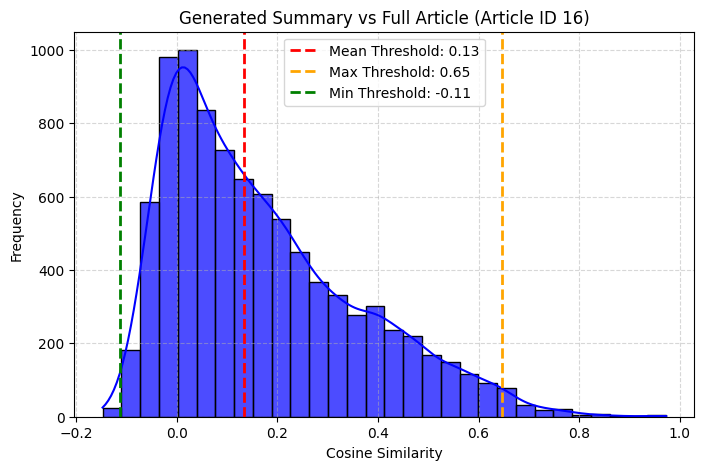

KDE-based threshold for mean: 0.1657
KDE-based threshold for max: 0.7176
KDE-based threshold for min: -0.0894


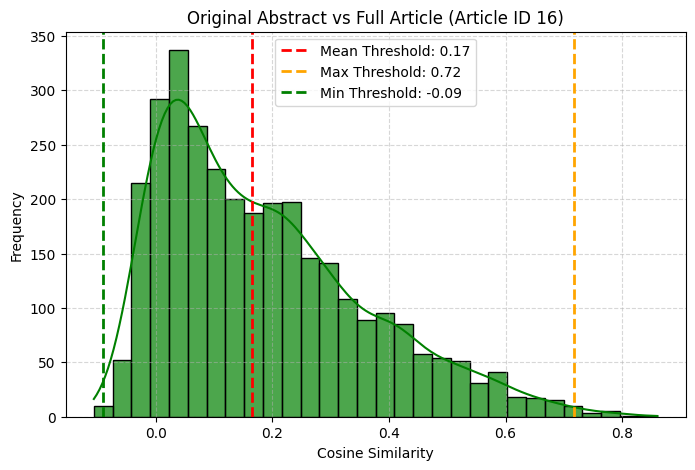


Article Title: Normal Behaviour Models for Wind Turbine Vibrations: Comparison of Neural Networks and a Stochastic Approach

Detected Hallucinations (Mean Similarity):
Level: basic
Summary Sentence: They have a complex system that includes blades that catch the wind and convert it into rotational energy.
Similarity Score: 0.0960
Most Similar Article Sentence: The turbine is subjected most of the time to undisturbed inﬂow due to its position in the ﬁrst row of turbines, located at the western past of the wind farm.
--------------------------------------------------
Level: basic
Summary Sentence: This energy is then converted into electricity through a generator.
Similarity Score: 0.0747
Most Similar Article Sentence: Energy Convers.
--------------------------------------------------
Level: basic
Summary Sentence: These vibrations can lead to damage to the blades and other components of the turbine.
Similarity Score: 0.1093
Most Similar Article Sentence: Vibrations in wind turbines redu

In [52]:
article_ids = list(range(len(df)))

# run detection
stats_df, results, all_sims = detect_hallucinations_multiple(
    article_ids, df, retriever, qa_chain, sim_model
)

### <a id="trends"></a> 4.5) Overall Hallucination Trends

This section provides a summary of hallucination detection statistics aggregated across all articles. The resulting `stats_df` data frame contains counts of hallucinated sentences per article under each detection strategy—mean similarity, max similarity, min similarity, and the intersection of mean and max. This enables a systematic comparison of how different thresholds perform across the dataset. The printed summary helps identify which articles had the most hallucinated content and under which criteria.

[⬆️ Back to Top](#top)


In [53]:
print("\n--- Summary of Hallucination Statistics ---")
stats_df


--- Summary of Hallucination Statistics ---


article_id                                      article_title  mean_count  \
0            0  Advanced Passive Operating System Fingerprinti...           2   
1            1  Artificial intelligence in the fertility clini...           6   
2            2  EvoDynamic: A Framework for the Evolution of G...           2   
3            3  A general representation of dynamical systems ...           2   
4            4  Exploring Multilingual Word Embedding Alignmen...           3   
5            5  A Deep Learning-Based Tool for Automatic Brain...           3   
6            6         Genetic Algorithms For Tightening Security           8   
7            7  How (not to) Run an AI Project in Investigativ...           1   
8            8  A New Adaptive Mixture Distance-Based Improved...           3   
9            9  A sensitivity analysis of cellular automata an...           2   
10          10  Influence of neural network bursts on function...           2   
11          11              Hadoop MapReduce scheduling paradigms           5   
12          12  An Intelligent Collaborative Image-Sensing Sys...           6   
13          13  Solving Two-Person Zero-Sum Stochastic Games W...           8   
14          14         Artificial intelligence in dry eye disease           4   
15          15  Achieving Fair Load Balancing by Invoking a Le...           3   
16          16  Normal Behaviour Models for Wind Turbine Vibra...           6   

    max_count  min_count  both_count  mean_threshold  max_threshold  \
0           2          2           2        0.188041       0.711021   
1          14          7           6        0.106981       0.669217   
2           2          2           2        0.161504       0.670951   
3           2          2           1        0.120043       0.582591   
4           3          3           2        0.312711       0.667598   
5           3          3           1        0.164043       0.762858   
6           8          3           7        0.216296       0.782067   
7           2          2           1        0.206386       0.773708   
8           3          3           0        0.113459       0.783176   
9           2          4           0        0.165033       0.711710   
10          2          2           2        0.113139       0.653411   
11          5          5           3        0.272065       0.679747   
12         18         11           5        0.114314       0.863122   
13          3          2           3        0.146540       0.689241   
14          4          4           3        0.189681       0.747024   
15          3          3           2        0.101397       0.625614   
16          5          5           4        0.133986       0.647545   

    min_threshold  
0       -0.087555  
1       -0.095045  
2       -0.121474  
3       -0.101972  
4       -0.060420  
5       -0.079269  
6       -0.091383  
7       -0.112329  
8       -0.132044  
9       -0.127462  
10      -0.127375  
11      -0.064576  
12      -0.098942  
13      -0.157514  
14      -0.088861  
15      -0.122853  
16      -0.112802

## <a id="case-study"></a> 5) HaluEval Benchmark Case Study

In [54]:
# clone the HaluEval benchmark repository from GitHub
!git clone https://github.com/RUCAIBox/HaluEval.git

Cloning into 'HaluEval'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 171 (delta 5), reused 2 (delta 2), pack-reused 141 (from 2)
Receiving objects: 100% (171/171), 39.21 MiB | 31.01 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [55]:
# list the contents of the HaluEval dataset directory
!ls HaluEval/data

dialogue_data.json  general_data.json  qa_data.json  summarization_data.json


### <a id="load-process"></a> 5.1) Load and Process Dataset

This section loads the HaluEval benchmark dataset from a `.jsonl` file. Each entry includes a document, a ground-truth summary, and a hallucinated summary. To simulate realistic use conditions, a random selection is made between the hallucinated and factual summary for each article. The selected summaries, along with their labels and associated metadata, are stored in a structured DataFrame for downstream hallucination detection. The raw JSON data is also returned to support inspection and debugging.

[⬆️ Back to Top](#top)

In [56]:
def load_halu_eval(filepath):
    """
    Load the HaluEval dataset and randomly select either
    a hallucinated or ground-truth summary per entry.

    Args:
        filepath: Path to the HaluEval file.

    Returns:
        tuple: (DataFrame with summaries and labels, raw JSON data list).
    """
    halu_data = []

    # read each line in the file as a separate JSON object
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            halu_data.append(json.loads(line.strip()))

    data = []

    # randomly choose either the hallucinated or ground-truth summary for each article
    for i, item in enumerate(halu_data):
        if random.random() < 0.5:
            chosen_summary = item["hallucinated_summary"]
            is_hallucinated_summary = 1
        else:
            chosen_summary = item["right_summary"]
            is_hallucinated_summary = 0

        data.append({
            "article_id": i,
            "title": f"HaluEval Sample {i}",
            "cleaned_content": item["document"],
            "summary": chosen_summary,
            "ground_truth_summary": item["right_summary"],
            "is_hallucinated_summary": is_hallucinated_summary
        })

    # create data frame for further processing
    halu_df = pd.DataFrame(data)
    return halu_df, halu_data

In [57]:
# load HaluEval dataset and print first raw JSON example
halu_df, halu_data = load_halu_eval("HaluEval/data/summarization_data.json")
print(json.dumps(halu_data[0], indent=2))

{
  "document": "Marseille, France (CNN)The French prosecutor leading an investigation into the crash of Germanwings Flight 9525 insisted Wednesday that he was not aware of any video footage from on board the plane. Marseille prosecutor Brice Robin told CNN that \"so far no videos were used in the crash investigation.\" He added, \"A person who has such a video needs to immediately give it to the investigators.\" Robin's comments follow claims by two magazines, German daily Bild and French Paris Match, of a cell phone video showing the harrowing final seconds from on board Germanwings Flight 9525 as it crashed into the French Alps. All 150 on board were killed. Paris Match and Bild reported that the video was recovered from a phone at the wreckage site. The two publications described the supposed video, but did not post it on their websites. The publications said that they watched the video, which was found by a source close to the investigation. \"One can hear cries of 'My God' in sev

### <a id="max-cosine"></a> 5.2) Detect Sentence-Level Hallucinations

This section implements a method for identifying hallucinated sentences in summaries based on their maximum semantic and lexical similarity to article content. Each summary sentence is compared to all article sentences using cosine similarity between sentence embeddings. A sentence is flagged as hallucinated if its highest similarity score falls below a specified threshold *and* it is not lexically similar to any article sentence, based on character-level sequence matching. This combined approach helps distinguish unsupported content from legitimate paraphrases, improving detection robustness.

[⬆️ Back to Top](#top)

In [58]:
def is_lexically_similar(a, b, threshold=0.6):
    """
    Returns True if two strings are lexically similar based on a sequence matching ratio.

    Args:
        a: First string to compare.
        b: Second string to compare.
        threshold: Similarity threshold between 0 and 1.

    Returns:
        bool: True if similarity ratio >= threshold, otherwise False.
    """
    return difflib.SequenceMatcher(None, a, b).ratio() >= threshold

In [59]:
def detect_max_similarity(article_id, df, sim_model, summary_type, threshold=0.6):
    """
    Detects hallucinated summary sentences using cosine and lexical similarity.

    Args:
        article_id: Row index in the DataFrame.
        df: Dataset with articles and summaries.
        sim_model: Embedding model.
        summary_type: Column name of the summary.
        threshold: Similarity cutoff for flagging hallucinations.

    Returns:
        tuple: (list of flagged sentences, list of hallucinated indices)
    """

    # extract content and split into sentences
    row = df.iloc[article_id]
    article_sentences = sentence_splitting(row["cleaned_content"])
    summary_sentences = sentence_splitting(row[summary_type])

    # handle empty cases
    if not article_sentences or not summary_sentences:
        return [], []

    # compute embeddings and similarity matrix
    article_embeds = sim_model.encode(article_sentences, convert_to_tensor=True).cpu()
    summary_embeds = sim_model.encode(summary_sentences, convert_to_tensor=True).cpu()
    similarity_matrix = cosine_similarity(summary_embeds, article_embeds)

    results, hallucinated_indices = [], []

    # analyze similarity scores for each summary sentence
    for idx, row_sim in enumerate(similarity_matrix):
        max_sim = np.max(row_sim)
        most_similar = article_sentences[np.argmax(row_sim)]

        # flag sentence as hallucinated if similarity is low and it's not lexically similar
        if max_sim < threshold and not is_lexically_similar(summary_sentences[idx], most_similar):
            hallucinated_indices.append(idx)
            results.append({
                "article_id": article_id,
                "title": row["title"],
                "source": summary_type,
                "summary_sentence": summary_sentences[idx],
                "similarity_score": max_sim,
                "most_similar_article_sentence": most_similar,
                "summary_sentence_idx": idx
            })
    return results, hallucinated_indices

### <a id="comparison2"></a> 5.3) Compare Sentences against Ground Truth Summaries

This step evaluates hallucination detection performance by comparing each sentence in a model-generated summary to the full article content. Using cosine similarity and lexical matching, each sentence is assessed for alignment with the article. If a sentence fails to meet the semantic similarity threshold and lacks lexical overlap with any article sentence, it is flagged as hallucinated. These predictions are then matched against the ground truth label (whether the summary is known to be hallucinated or not) to compute sentence-level accuracy, precision, recall, and other metrics.

[⬆️ Back to Top](#top)

In [60]:
def compute_sentence_level_labels(df, sim_model, subset_size, threshold):
    """
    Labels each summary sentence as factual or hallucinated based on similarity to the original article.

    Args:
        df: Dataset with summaries and article documents.
        sim_model: Embedding model.
        subset_size: Number of articles to evaluate.
        threshold: Similarity threshold for hallucination detection.

    Returns:
        tuple: (data frame of comparisons, list of true labels, list of predicted labels)
    """
    comparisons, y_true, y_pred = [], [], []

    # iterate through a subset of the dataset
    for i, row in tqdm(df.head(subset_size).iterrows(), total=subset_size):

        # detect hallucinated sentence indices based on similarity threshold
        hallucinated, hallucinated_idx = detect_max_similarity(i, df, sim_model, "summary", threshold)

        # split summary and article into sentences
        summary_sentences = sentence_splitting(row["summary"])
        article_sentences = sentence_splitting(row["cleaned_content"])

        # skip entries with empty sentence lists
        if not summary_sentences or not article_sentences:
            continue

        # compute embeddings and pairwise cosine similarities
        article_embeds = sim_model.encode(article_sentences, convert_to_tensor=True).cpu()
        summary_embeds = sim_model.encode(summary_sentences, convert_to_tensor=True).cpu()
        similarity_matrix = cosine_similarity(summary_embeds, article_embeds)

        # evaluate each summary sentence
        for j, sent in enumerate(summary_sentences):
            row_sim = similarity_matrix[j]
            max_sim = np.max(row_sim)
            most_similar_sentence = article_sentences[np.argmax(row_sim)]

            # ground truth: 1 if summary was hallucinated, else 0
            true_label = 1 if row["is_hallucinated_summary"] else 0

            # prediction: 1 if this sentence was flagged as hallucinated
            pred_label = 1 if j in hallucinated_idx else 0
            y_true.append(true_label)
            y_pred.append(pred_label)

            # record comparison result
            comparisons.append({
                "article_id": i,
                "summary_sentence": sent,
                "similarity_score": max_sim,
                "most_similar_article_sentence": most_similar_sentence,
                "ground_truth_summary": row["ground_truth_summary"],
                "is_hallucinated_summary": true_label,
                "predicted_hallucination": pred_label
            })

    return pd.DataFrame(comparisons), y_true, y_pred

### <a id="summary-eval"></a> 5.4) Evaluate Summary-Level Classification Metrics

This section evaluates hallucination detection at the summary level by aggregating sentence-level results. For each summary, the number of hallucinated sentences is calculated using a cosine similarity-based method. A summary is classified as hallucinated if the proportion of flagged sentences exceeds a configurable threshold (e.g., 30%). The evaluation is repeated over a range of similarity thresholds to analyze how performance varies. Key metrics such as F1 score, precision, recall, and ROC-AUC are computed and visualized, helping to determine the most effective detection threshold for summary-level classification.

[⬆️ Back to Top](#top)

In [61]:
def evaluate_summary_level(df, sim_model, subset_size, thresholds_values, hallucination_fraction_threshold):
    """
    Evaluates summary-level hallucination detection using different similarity thresholds.

    Args:
        df: Dataset with summaries and labels.
        sim_model: Embedding model.
        subset_size: Number of samples to evaluate.
        thresholds_values: List of similarity thresholds to test.
        hallucination_fraction_threshold: Minimum fraction of hallucinated sentences to flag a summary.

    Returns:
        tuple: (lists of F1, precision, recall, and ROC-AUC scores)
    """
    f1_scores, precision_scores, recall_scores, roc_auc_scores = [], [], [], []

    for threshold in thresholds_values:
        print(f"Evaluating at threshold {threshold:.2f}")
        y_true, y_pred = [], []
        for i, row in tqdm(df.head(subset_size).iterrows(), total=subset_size):

            # detect hallucinated sentences using the current threshold
            _, hallucinated_idx = detect_max_similarity(i, df, sim_model, "summary", threshold)

            # compute fraction of hallucinated sentences in the summary
            summary_sentences = sentence_splitting(row["summary"])
            fraction = len(hallucinated_idx) / len(summary_sentences)

            # predict hallucinated summary if fraction exceeds threshold
            y_pred.append(1 if fraction > hallucination_fraction_threshold else 0)
            y_true.append(row["is_hallucinated_summary"])

        # calculate metrics for this threshold
        f1_scores.append(f1_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        roc_auc_scores.append(roc_auc_score(y_true, y_pred))

    # plot performance metrics over thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds_values, f1_scores, label="F1 Score", marker='o')
    plt.plot(thresholds_values, precision_scores, label="Precision", marker='o')
    plt.plot(thresholds_values, recall_scores, label="Recall", marker='o')
    plt.plot(thresholds_values, roc_auc_scores, label="ROC-AUC", marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Summary-Level Performance vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    return f1_scores, precision_scores, recall_scores, roc_auc_scores

### <a id="classification-visuals"></a> 5.5) Categorize Sentences and Analyze Distribution

This section classifies summary sentences into distinct categories based on their semantic similarity scores to the article. Sentences are split into **possible hallucinations** (below a lower threshold) and **likely grounded** (above an upper threshold), excluding short sentences that are more ambiguous. These categories help quantify the confidence level of hallucination detection and guide interpretability.

To evaluate sentence-level classification, precision, recall, F1 score, and ROC-AUC are computed. A confusion matrix heatmap is plotted to visualize true and false predictions. Additionally, a pie chart shows the overall distribution of grounded vs. possibly hallucinated sentences in the dataset, giving insight into the prevalence of different factuality levels across summaries.

[⬆️ Back to Top](#top)

In [62]:
def classify_hallucinations(sentence_df, possible_threshold, min_word_count=6):
    """
    Classifies sentences into possible or grounded based on similarity scores,
    excluding short sentences.

    Args:
        sentence_df: DataFrame with sentence-level similarity scores.
        possible_threshold: Upper bound for possibly hallucinated sentences.
        min_word_count: Minimum number of words required to include a sentence.

    Returns:
        tuple: (possible, grounded) sentence subsets
    """
    # filter out short sentences
    filtered_df = sentence_df[sentence_df["summary_sentence"].str.split().str.len() >= min_word_count]

    # possible hallucinations
    possible = filtered_df[filtered_df["similarity_score"] < possible_threshold]

    # grounded sentences
    grounded = filtered_df[filtered_df["similarity_score"] >= possible_threshold]

    return possible, grounded

In [63]:
def compute_and_plot_metrics(y_true, y_pred, title="Metrics"):
    """
    Computes and displays classification metrics and a confusion matrix heatmap.

    Args:
        y_true: Ground truth binary labels.
        y_pred: Predicted binary labels.
        title: Title for the confusion matrix plot.
    """
    # compute standard classification metrics
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # print metric values
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Grounded", "Hallucinated"],
                yticklabels=["Grounded", "Hallucinated"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [64]:
def plot_hallucination_distribution(possible_count, grounded_count):
    """
    Plots a pie chart showing the distribution of only possible and grounded sentence types.

    Args:
        possible_count: Number of possibly hallucinated sentences.
        grounded_count: Number of grounded sentences.
    """
    labels = ["Possible Hallucination", "Likely Grounded"]
    sizes = [possible_count, grounded_count]
    colors = ["orange", "blue"]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
    plt.title("Distribution of Sentence Types")
    plt.axis("equal")
    plt.show()

In [65]:
# load embedding model
sim_model = SentenceTransformer("all-mpnet-base-v2")

# sentence-level evaluation
threshold = 0.6
sentence_df, y_true_sent, y_pred_sent = compute_sentence_level_labels(
    halu_df, sim_model, subset_size=10000, threshold=threshold
)

100%|██████████| 10000/10000 [41:37<00:00,  4.00it/s]


Evaluating at threshold 0.70


100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


Evaluating at threshold 0.80


100%|██████████| 1000/1000 [02:04<00:00,  8.01it/s]


Evaluating at threshold 0.90


100%|██████████| 1000/1000 [02:06<00:00,  7.94it/s]


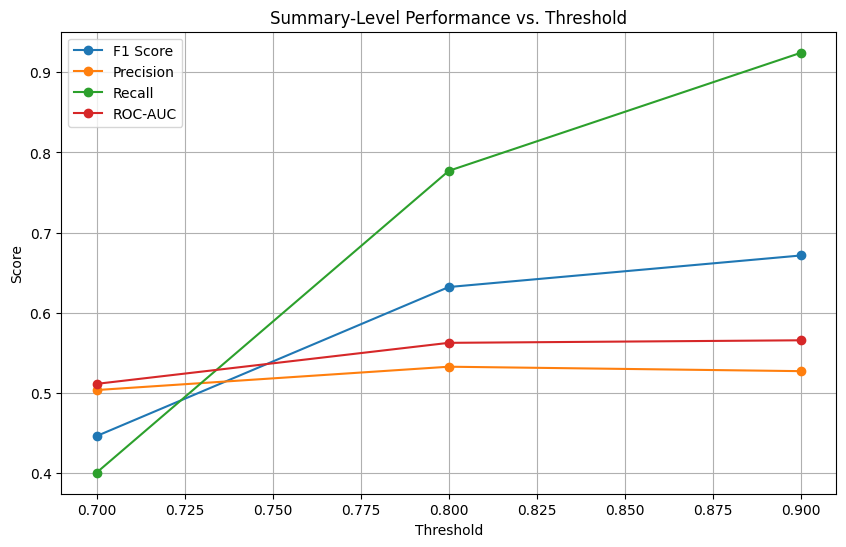

Best threshold: 0.90


In [66]:
# summary-level evaluation
thresholds_values = [0.7, 0.8, 0.9]
f1_scores, precision_scores, recall_scores, roc_auc_scores = evaluate_summary_level(
    halu_df, sim_model, subset_size=1000, thresholds_values=thresholds_values, hallucination_fraction_threshold=0.6
)

# best threshold selection
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_values[best_idx]
print(f"Best threshold: {best_threshold:.2f}")

100%|██████████| 10000/10000 [20:53<00:00,  7.98it/s]


F1 Score: 0.6724
Precision: 0.5356
Recall: 0.9030
ROC-AUC: 0.5618
Confusion Matrix:
[[1105 3906]
 [ 484 4505]]


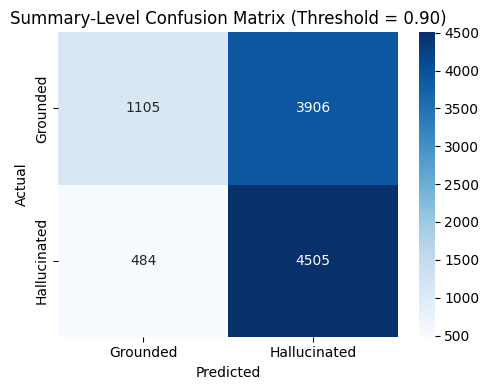

In [67]:
# final summary classification with best threshold
y_true, y_pred = [], []

for i, row in tqdm(halu_df.head(10000).iterrows(), total=10000):

    # detect hallucinated sentence indices using max similarity threshold
    _, hallucinated_idx = detect_max_similarity(i, halu_df, sim_model, "summary", best_threshold)

    # split summary into individual sentences
    summary_sentences = sentence_splitting(row["summary"])

    # compute fraction of sentences flagged as hallucinated
    fraction = len(hallucinated_idx) / len(summary_sentences)

    # classify entire summary as hallucinated if hallucinated fraction exceeds 60%
    y_pred.append(1 if fraction > 0.6 else 0)

    # ground truth: whether the selected summary was hallucinated in the dataset
    y_true.append(row["is_hallucinated_summary"])

# evaluate classification performance and display metrics
compute_and_plot_metrics(y_true, y_pred, title=f"Summary-Level Confusion Matrix (Threshold = {best_threshold:.2f})")

In [68]:
# define thresholds
grounded_threshold = 0.90
possible_threshold = 0.45

# filter possible hallucinations
possible_df = sentence_df[sentence_df['similarity_score'] < possible_threshold]

# filter grounded sentences
grounded_df = sentence_df[sentence_df['similarity_score'] >= grounded_threshold]

In [69]:
pd.set_option("display.max_colwidth", None)

# display top possible hallucinations
print("\nTop 5 Possible Hallucinations:")
display(possible_df.head(5))

# display top grounded sentences
print("\nTop 5 Grounded Sentences:")
display(grounded_df.head(5))


Top 5 Possible Hallucinations:


article_id  \
36           12   
80           27   
107          37   
130          45   
172          60   

                                                                                                                                          summary_sentence  \
36   Tourists visiting California can expect to be greeted with free glasses of water at restaurants and lavish decorative fountains in residential areas.   
80                                                                                                                    Political sparring continues in U.S.   
107                                                                                                                      The restart was delayed in March.   
130                                                                                                                                               The U.S.   
172                                                                                                                  His record on rights shows otherwise.   

     similarity_score  \
36           0.442906   
80           0.419986   
107          0.261431   
130          0.327646   
172          0.388719   

                                                                                                                                                                                                                most_similar_article_sentence  \
36                                                                                                                           So the next time you take a holiday in California, you'll find a few changes around here, thanks to the drought.   
80                                                                                                                                                                                                         On Sunday, the sparring continued.   
107  After problems that delayed the restart in March, scientists at the European Organization for Nuclear Research (CERN) completed final tests, enabling the first beams to start circulating Sunday inside the LHC's 17 mile (27 km) ring.   
130                                                                                                                                                                                  Seoul, South Korea (CNN)The man accused of stabbing U.S.   
172                                                                                                            But Paul has also questioned the Civil Rights Act, and even claimed that private business owners have a right to discriminate.   

                                                                                                                                                                                                                                                              ground_truth_summary  \
36                              Americans paid more for some fruits and vegetables last year because of the drought. Tourists will now have to ask for a glass of water at a California restaurant. Perhaps the only good thing is another "great" wine grape harvest last year.\n   
80                                                                                                                                            Netanyahu says third option is "standing firm" to get a better deal. Political sparring continues in U.S. over the deal with Iran.\n   
107                                                                                                                                                                    The Large Hadron Collider (LHC) begins again after a two-year shutdown. The restart was delayed in March.\n   
130                                                 Kim Ki-Jong is charged with attempted murder and assaulting a foreign envoy. He's accused of stabbing U.S. Ambassador Mark Lippert in the face and arm. Police said Kim opposed the


Top 5 Grounded Sentences:


article_id  \
2             0   
11            3   
19            6   
69           23   
170          59   

                                                                                                        summary_sentence  \
2            Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression, airline says.   
11   Amnesty International releases its annual review of the death penalty worldwide; much of it makes for grim reading.   
19                                                                                                              The Rev.   
69                                            Parts of South America, India, China and Russia also will see the eclipse.   
170                                           Justice Department has initiated a criminal investigation into the matter.   

     similarity_score  \
2            0.922713   
11           0.910124   
19           1.000000   
69           0.905129   
170          0.934511   

                                                                                                                                               most_similar_article_sentence  \
2                                  Lubitz told his Lufthansa flight training school in 2009 that he had a "previous episode of severe depression," the airline said Tuesday.   
11                                                                                   Today, Amnesty International releases its annual review of the death penalty worldwide.   
19                                                                                                                                                                  The Rev.   
69   Parts of South America, India, China and Russia also will be able to see the eclipse, but it won't be visible in Greenland, Iceland, Europe, Africa or the Middle East.   
170                                                                        Department of Justice has initiated a criminal investigation into the matter, according to a U.S.   

                                                                                                                                                                                                                                                                                                        ground_truth_summary  \
2    Marseille prosecutor says "so far no videos were used in the crash investigation" despite media reports. Journalists at Bild and Paris Match are "very confident" the video clip is real, an editor says. Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression, airline says.\n   
11                                                                                                 Amnesty International releases its annual review of the death penalty worldwide; much of it makes for grim reading. Salil Shetty: Countries that use executions to deal with problems are on the wrong side of history.\n   
19                                                                                                                                                           The Rev. Robert Schuller, 88, had been diagnosed with esophageal cancer in 2013. His TV show, "Hour of Power," was enormously popular in the 1970s and 1980s.\n   
69                                                                                                                     The total eclipse will only last 4 minutes and 43 seconds. People west of the Mississippi River will have the best view. Parts of South America, India, China and Russia also will see the eclipse.\n   
170                                                                    Delaware family becomes ill at the Sirenusa resort in the U.S. Virgin Islands. Preliminary EPA results find methyl bromide was present in unit where family stayed. U.S. Justice Department has initiated a criminal investigation into the matter.\n   

     is_hallucin

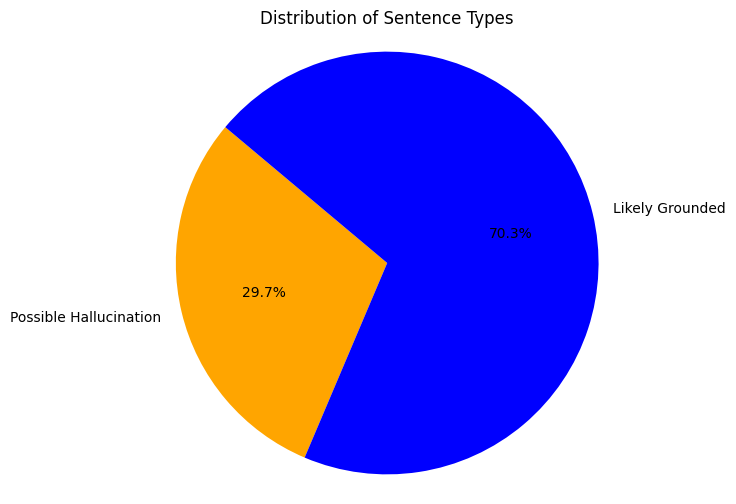

In [70]:
# plot distribution
plot_hallucination_distribution(len(possible_df), len(grounded_df))

In [71]:
# show the most likely hallucinated sentence (lowest similarity score)
lowest_possible = possible_df.sort_values(by="similarity_score", ascending=True).head(10)

print("\nMost Likely Hallucinated Sentence (Lowest Similarity):")
display(lowest_possible)


Most Likely Hallucinated Sentence (Lowest Similarity):


article_id                                     summary_sentence  \
6438         2085                      and that's the real issue here.   
15010        4510  CLICK HERE for all the latest news from Charleston.   
15770        4723                    they're more or less nonexistent.   
15769        4723    You won't have to agonise over pages of extras...   
1839          660                                           Clarke Jr.   
12516        3839                                        The World No.   
3492         1208                                   and what he meant.   
15761        4723                                          Always fun.   
4057         1382                                        The world No.   
29814        8405                          for an academic conference.   

       similarity_score  \
6438           0.055655   
15010          0.111916   
15770          0.120578   
15769          0.121946   
1839           0.129571   
12516          0.138645   
3492           0.140403   
15761          0.143543   
4057           0.144572   
29814          0.145249   

                                                                                                                                                                                                                                                   most_similar_article_sentence  \
6438                                                                                  The trip to Ewood Park for a quarter-final replay has even more significance as in comes in the wake of successive morale-sapping Premier League defeats by Manchester United and Arsenal.   
15010                                                                                                                                                 Davis won nine of the final 11 games of the match and broke Bouchard's serve twice in the final set to pull off the upset.   
15770                                                                                                            As a result of the Land Rover Defender's demise, there could be a boom in sales of a Russian badge which was a butt of many jokes in the Soviet era – the Lada.   
15769                                                                                        Forget luxuries because the Niva is an unabashed frills-free zone, the upside of its simplicity is that the plastic interior (pictured) is easy to mop down after a day in the mud.   
1839   Every day, thousands of police officers and deputies enforce traffic laws, execute arrest and search warrants, investigate domestic violence complaints and perform countless tasks that are needed to keep our neighborhoods safe and remove criminals from the streets.   
12516                                                                                                                                                                  World No 4 swept past Almagro on Wednesday as looks for his ninth career title on the Catalan clay court.   
3492                                                                                                 The 20-year-old wideman edged closer towards an Anfield exit after revealing in an interview with the BBC on Wednesday that he would have signed for a lot less a year ago.   
15761                                                                                                            As a result of the Land Rover Defender's demise, there could be a boom in sales of a Russian badge which was a butt of many jokes in the Soviet era – the Lada.   
4057                                                                                                                                                                                                                   The heaviest weight I would ever lift was my body weight.   
29814                                                                            During opening statements this week, Senior Deputy Di